# Load Libraries and Functions

In [1]:
# System, Data, Time, and Spec Libraries
import os
import pandas as pd
import time
import random
from datetime import datetime, timedelta
import numpy as np 
from line_profiler import LineProfiler  # Code peformance
profiler = LineProfiler()
import warnings
warnings.filterwarnings('ignore')
import csv
#pd.set_option('display.max_colwidth', None)
import multiprocess as mp
num_cores = mp.cpu_count()

# Data Visualization Libraries
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.express as px
import seaborn as sns
#from pandas.io.json import json_normalize  # Older version
from pandas import json_normalize  # Newer version


# Natural Language Processing Libraries
import json
import requests
import xml.etree.ElementTree as ET
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import string
import nltk
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from pandas import json_normalize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.util import ngrams
from nltk.corpus import stopwords
from string import punctuation
punctuation = set(punctuation)
punctuation.update({'_', '-','‘'})
english_words = set(words.words())
from fuzzywuzzy import process
#nltk.download('words')
#nltk.download('punkt')
#nltk.download('stopwords')

# SQL Interface Libraries
import pymysql as mysql
import mysql.connector
import pyodbc
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import event
from string import punctuation

# Importing Custom Functions
import nbimporter
from Functions import process_text, add_sequential_index, process_label_text, remove_duplicates_nan
from Functions import classify_product_type, nan_info, plot_character_length, convert_to_years, examine_text_outliers
from Functions import process_company_text, clean_manufacturer_text, clean_data


### Test Multiprocessing with Script

In [2]:
def f(x):
    return x*x

# should add if __name__ == '__main__': protection to protect against infinite process creation
if __name__ == '__main__':
    with mp.Pool(5) as pool:
        print(pool.map(f, [1, 2, 3, 4, 5]))

[1, 4, 9, 16, 25]


# API Keys and Passwords

In [5]:
# mysql password
PASSWORD = "PASSWORD"

# openFDA API Key
openFDAAPI = "E9AA90Q9ntbRnUu0MuXGVPchoquUCFgNhbmZ8pOk"  # Halee

# Data.Medicaid API Key

In [ ]:
# Code to assess performance
# Still need to implement
#from line_profiler import LineProfiler

#def your_function():
    # Your code here


#profiler.add_function(your_function)
#profiler.run('your_function()')
#profiler.print_stats()

# FDA Data

## API Request for Historical Text Documents

https://open.fda.gov/apis/other/historicaldocument/

In [6]:
# Time API call
start_time = time.time() 

# OpenFDA API endpoint for fetching historical documents
BASE_URL = 'https://api.fda.gov/other/historicaldocument.json'

## API Key for authentication
API_KEY = openFDAAPI

# Parameters for the API request
params = {
    'limit': 1000,  # Adjust the limit as needed
    'skip': 0       # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data(max_requests):
    documents = []
    request_count = 0  # Initialize request counter
   
    while request_count < max_requests:
        headers = {
            'Authorization': f'Bearer {API_KEY}'
        }
        response = requests.get(BASE_URL, params=params, headers=headers)


        #print(f"Requesting data with params: {params}")  # Debugging statement
        #print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
       
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            doc_type = item.get('doc_type', 'N/A')
            year = item.get('year', 'N/A')
            text = item.get('text', 'N/A')
            document = {'doc_type': doc_type, 'year': year, 'text': text}
            if document not in documents:
                documents.append(document)
       
        params['skip'] += params['limit']
        request_count += 1  # Increment request counter
        pause_execution()

        print('.', end='', flush=True)

    return documents

# Fetch the data
documents = fetch_data(max_requests=10)

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"Request Time:" , execution_time)

.........Failed to fetch data: 404
Request Time: 19.657913208007812


In [7]:
# Save the data to a dataframe
documents_df = pd.DataFrame(documents)
documents_df.head()

,doc_type,year,text
0,pr,2006,FDA NEWS RELEASE\nFOR IMMEDIATE RELEASE\n\nFeb...
1,pr,2006,FDA NEWS RELEASE\nFOR IMMEDIATE RELEASE\n\nFeb...
2,talk,1991,I FOOD _-AND DRUG ADMINISTRATION ‘ 'i\nU. S. D...
3,pr,1934,iNFORMATION FOR THE PRESS\n\nu 8. DEPARTMENT O...
4,pr,1975,\n\nU. S. DEPARTMENT OF HEALTH. EDUCATION. AN...


In [ ]:
# 8854 documents at time of project creation
documents_df.info()

In [297]:
# Save csv file to data library
#csv_file_path = 'DataLibrary/raw_documents.csv'
#documents_df.to_csv(csv_file_path, index=False)

## API Request for Adverse Events Data

https://open.fda.gov/apis/drug/event/

In [8]:
# Time the API call
start_time = time.time()

# OpenFDA API endpoint for fetching drug event data
BASE_URL = 'https://api.fda.gov/drug/event.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the API request
params = {
    'limit': 1000,  # Maximum limit per request
    'skip': 0       # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data(max_requests):
    events = []
    request_count = 0  # Initialize request counter
   
    while request_count < max_requests:
        headers = {
            'Authorization': f'Bearer {API_KEY}'
        }
        response = requests.get(BASE_URL, params=params, headers=headers)
        #print(f"Requesting data with params: {params}")  # Debugging statement
        #print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
       
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            events.append(item)
       
        params['skip'] += params['limit']
        request_count += 1  # Increment request counter
        pause_execution()

        print('.', end='', flush=True)

    return events

# Fetch the data
events = fetch_data(max_requests=10)

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"Request Time:" , execution_time)

..........Request Time: 40.47154498100281


In [9]:
# Convert the data to a pandas DataFrame
events_df = pd.json_normalize(events)

# Display the first few rows of the DataFrame
events_df.head()

,safetyreportid,transmissiondateformat,transmissiondate,serious,seriousnessdeath,receivedateformat,receivedate,receiptdateformat,receiptdate,fulfillexpeditecriteria,...,occurcountry,patient.patientagegroup,seriousnesshospitalization,patient.summary.narrativeincludeclinical,seriousnesslifethreatening,patient.patientweight,primarysource.literaturereference,seriousnesscongenitalanomali,authoritynumb,reportduplicate
0,5801206-7,102,20090109,1,1,102,20080707,102,20080625,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10003300,102,20141002,1,NaN,102,20140306,102,20140306,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10003301,102,20141002,1,NaN,102,20140228,102,20140228,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10003302,102,20141002,2,NaN,102,20140312,102,20140312,2,...,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10003304,102,20141212,2,NaN,102,20140312,102,20140424,2,...,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
events_df.info()

#### Examine Variables of Interest

In [ ]:
# 2 - Yes, 1 - No
events_df['fulfillexpeditecriteria'].value_counts()

In [ ]:
# 5 - Consumer/NonHealth, 4 - Lawyer, 3 - Health Professional, 4 - Pharmacist, 5 - MD
events_df['primarysource.qualification'].value_counts()

In [ ]:
# 1 - Yes (death/hospitalization/lifethreatening/other/birthdefect), 2 - No
events_df['serious'].value_counts()

In [ ]:
# 1 - Death, 2 - Other 
events_df['seriousnessdeath'].value_counts()

In [ ]:
# Distribution of Age
plt.hist(events_df['patient.patientonsetage'].astype('float'))
ticks = np.arange(0, 100, 5)  # Customize this range as needed
plt.xticks(ticks)
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Age Distribution FAERS')
plt.show()

In [ ]:
# Ages come in different units, need to standardize to years
events_df['patient.patientonsetageunit'].value_counts()

In [ ]:
# Some reports have more than one version, retain most recent versions only
events_df['safetyreportversion'].value_counts()

In [ ]:
# Can see manufacturers where most reports were duplicated
events_df['reportduplicate.duplicatesource'].value_counts()

In [ ]:
# Save the data to a CSV file
#csv_file_path = 'DataLibrary/raw_events.csv'
#events_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

## API Request for Drug Labels

https://open.fda.gov/apis/drug/label/

In [10]:
# Time API call
start_time = time.time()

# OpenFDA API endpoint for fetching drug label data
BASE_URL = 'https://api.fda.gov/drug/label.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the API request
params = {
    'limit': 1000,  # Maximum limit per request
    'skip': 0      # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data(max_requests):
    labels = []
    request_count = 0  # Initialize request counter
    
    while request_count < max_requests:
        headers = {
            'Authorization': f'Bearer {API_KEY}'
        }
        response = requests.get(BASE_URL, params=params, headers=headers)
  
        #print(f"Requesting data with params: {params}")  # Debugging statement
        #print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            labels.append(item)
        
        params['skip'] += params['limit']
        request_count += 1  # Increment request counter
        pause_execution()
        
        print('.', end='', flush=True)

    return labels

# Fetch the data
labels = fetch_data(max_requests=10)

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"Request Time:" , execution_time)

..........Request Time: 42.01439881324768


In [11]:
# Convert the data to a pandas DataFrame
labels_df = pd.json_normalize(labels)

# Display the first few rows of the DataFrame
labels_df.head()

,effective_time,inactive_ingredient,purpose,keep_out_of_reach_of_children,warnings,questions,spl_product_data_elements,version,dosage_and_administration,pregnancy_or_breast_feeding,...,keep_out_of_reach_of_children_table,boxed_warning_table,health_claim,alarms,laboratory_tests_table,health_care_provider_letter,summary_of_safety_and_effectiveness,health_care_provider_letter_table,guaranteed_analysis_of_feed,troubleshooting
0,20210902,[INACTIVE INGREDIENTS Sucrose],"[USES USES: Temporary Relief - Acne, Boils* * ...",[Keep this and all medication out of reach of ...,[WARNINGS This product is to be used for self-...,[QUESTIONS OR COMMENTS www.Rxhomeo.com | 1.888...,[SILICEA SILICEA SUCROSE SILICON DIOXIDE SILIC...,2,"[DOSAGE Adults- Take 4 or 6 Pellets by mouth, ...","[As with any drug, if you are pregnant, or nur...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20150109,"[INGREDIENTS: TALC, POLYMETHYL METHACRYLATE, V...",[Purpose Sunscreen],[Keep out of reach of children If product is s...,[Warnings For external use only.],NaN,[CHANTECAILLE PROTECTION NATURELLE BRONZE SPF ...,4,[Directions Protection Naturelle SPF 46 PA+++ ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20230802,[INACTIVE INGREDIENTS Sucrose/Lactose],[USES To relieve the symptoms of itching.],[KEEP OUT OF REACH OF CHILDREN Keep this and a...,[STOP USE AND ASK DOCTOR If symptoms persist/w...,NaN,[Mezereum DAPHNE MEZEREUM BARK SUCROSE LACTOSE...,3,[DIRECTIONS Adults: Dissolve 3 to 5 under the ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20230905,NaN,NaN,NaN,[WARNINGS NOT FOR INJECTION. Ofloxacin ophthal...,NaN,[Ofloxacin Ofloxacin OFLOXACIN OFLOXACIN Sodiu...,7,[DOSAGE AND ADMINISTRATION The recommended dos...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20230403,NaN,NaN,NaN,NaN,NaN,[Naproxen Naproxen NAPROXEN NAPROXEN CROSCARME...,27,[2 DOSAGE AND ADMINISTRATION Use the lowest ef...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pd.set_option('display.max_info_columns', 160)
labels_df.info()

In [ ]:
# Save the data to a CSV file
#csv_file_path = 'DataLibrary/raw_labels.csv'
#labels_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

## API Request for Manufacturer Information (NDC)

In [347]:
# Time API call
start_time = time.time()

# OpenFDA API endpoint for fetching drug label data
BASE_URL = 'https://api.fda.gov/drug/ndc.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the API request
params = {
    'limit': 1000,  # Maximum limit per request
    'skip': 0      # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data():
    manus = []
    
    while True:
        headers = {
            'Authorization': f'Bearer {API_KEY}'
        }
        response = requests.get(BASE_URL, params=params, headers=headers)
        #print(f"Requesting data with params: {params}")  # Debugging statement
        #print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            manus.append(item)
        
        params['skip'] += params['limit']
        pause_execution()
        
        print('.', end='', flush=True)

    return manus

# Fetch the data
manus = fetch_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time}")

..........................Failed to fetch data: 400

Request Time: 39.54959726333618


In [348]:
# Convert the data to a pandas DataFrame
manus_df = pd.json_normalize(manus)

# Display the first few rows of the DataFrame
manus_df.head()

,product_ndc,generic_name,labeler_name,brand_name,active_ingredients,finished,packaging,listing_expiration_date,marketing_category,dosage_form,...,pharm_class,openfda.upc,openfda.nui,openfda.pharm_class_moa,openfda.pharm_class_cs,openfda.pharm_class_epc,dea_schedule,marketing_end_date,openfda.pharm_class_pe,brand_name_suffix
0,11673-086,Ethyl Alcohol,Target Corp,Hand Sanitizer,"[{'name': 'ALCOHOL', 'strength': '567 mg/mL'}]",True,"[{'package_ndc': '11673-086-16', 'description'...",20241231,OTC MONOGRAPH NOT FINAL,GEL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11673-597,"acetaminophen, dextromethorphan HBr, doxylamin...",Target Corporation,Up and Up severe cold and flu,NaN,True,"[{'package_ndc': '11673-597-02', 'description'...",20241231,OTC MONOGRAPH FINAL,KIT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11673-991,IBUPROFEN,TARGET CORPORATION,IBUPROFEN,"[{'name': 'IBUPROFEN', 'strength': '200 mg/1'}]",True,"[{'package_ndc': '11673-991-01', 'description'...",20251231,ANDA,"TABLET, COATED",...,"[Anti-Inflammatory Agents, Non-Steroidal [CS],...","[0349483601886, 0349483601206, 0349483991505]","[N0000000160, M0001335, N0000175722]",[Cyclooxygenase Inhibitors [MoA]],"[Anti-Inflammatory Agents, Non-Steroidal [CS]]",[Nonsteroidal Anti-inflammatory Drug [EPC]],NaN,NaN,NaN,NaN
3,11822-0620,Loratadine,Rite Aid Corporation,childrens allergy relief,"[{'name': 'LORATADINE', 'strength': '5 mg/5mL'}]",True,"[{'package_ndc': '11822-0620-0', 'description'...",20241231,ANDA,SOLUTION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11822-3130,HYDROCORTISONE,Rite Aid,Rite Aid Anti-itch,"[{'name': 'HYDROCORTISONE', 'strength': '1 g/1...",True,"[{'package_ndc': '11822-3130-1', 'description'...",20241231,OTC MONOGRAPH DRUG,CREAM,...,[Corticosteroid Hormone Receptor Agonists [MoA...,NaN,"[N0000175576, N0000175450]",[Corticosteroid Hormone Receptor Agonists [MoA]],NaN,[Corticosteroid [EPC]],NaN,NaN,NaN,NaN


In [ ]:
pd.set_option('display.max_info_columns', 40)
manus_df.info()

In [349]:
manus_df.shape

(26000, 32)

# National Library of Medicine - Standardized Drug Names and Information

## API Request for RxNorm

https://lhncbc.nlm.nih.gov/RxNav/APIs/RxNormAPIs.html

In [ ]:
# Base URL for RxTerms API to get all drug names
#BASE_URL = 'https://rxnav.nlm.nih.gov/REST/RxTerms/rxcui'

# Function to pause execution to avoid overwhelming the server
#def pause_execution():
#    time.sleep(1 + 2 * random.random())

# Function to fetch data from the RxTerms API
#def fetch_data(max_requests):
#    drugs = []
#    start_rxcui = 1  # Starting RxCUI for the search
#    step = 500      # Step size to iterate through RxCUIs
#    request_count = 0  # Initialize request counter

#    while request_count < max_requests:
#        batch_drugs = []
#        for i in range(start_rxcui, start_rxcui + step):
#            url = f"{BASE_URL}/{i}/allinfo.json"
#            response = requests.get(url)

#            if response.status_code != 200:
#                print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
#                continue

#            if response.content.strip():  # Check if the response content is not empty
#                data = response.json()
#                properties = data.get('rxtermsProperties', {})

#                if properties:
#                    if properties.get('marketed', '').lower() == 'true':
#                        properties['rxcui'] = i
#                        batch_drugs.append(properties)

#        drugs.extend(batch_drugs)  # Add the batch results to the main list
#        print(f"Processed batch starting with RxCUI: {start_rxcui}")  # Debugging statement for each batch

        # Update the start_rxcui for the next batch
 #       start_rxcui += step
#      request_count += 1  # Increment request counter

        # Break condition to stop if no more data in the batch
#        if not batch_drugs:
#            break

#        pause_execution()

#    return drugs

# Fetch the data
#drugs = fetch_data(max_requests=1)

# Convert the data to a pandas DataFrame
#drugs_df = pd.DataFrame(drugs)

# Display the first few rows of the DataFrame
#drugs_df.head()

In [ ]:
# Save the data to a JSON file
#json_file_path = 'DataLibrary/rxterms_drugs.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(drugs, json_file, indent=4)

# Save the data to a CSV file
#csv_file_path = 'DataLibrary/rxterms_drugs.csv'
#drugs_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

# ADReCS Database for Standardized Drug and ADR Term Labeling

In [14]:
# load in static files
adrecs_drug = pd.read_excel('ADReCS/Drug_information_v3.3.xlsx')
adrecs_drug.head()

,DRUG_ID,DRUG_NAME,DRUG_SYNONYMS,DrugBank_ID,PubChem_ID,MESH_ID,KEGG_ID,TTD_ID
0,BADD_D00001,"1,2-hexanediol","1,2-hexanediol",DB14108,94335,C119102,Not Available,Not Available
1,BADD_D00002,2-hydroxy-3-phenylpropanoic acid,"3-phenyllactic acid | 3-phenyllactic acid, mon...",Not Available,3848,C017648,Not Available,Not Available
2,BADD_D00003,2-phenylbutyric acid,2-phenylbutyric acid | 2-phenylbutanoic acid,Not Available,7012,C039714,Not Available,Not Available
3,BADD_D00004,2-[1-methyl-5-(4-methylbenzoyl)pyrrol-2-yl]ace...,"Tolmetin | Tolectin | Tolmetin Sodium, Anhydro...",DB00500,5508,D014046,D00158; D02355,D09BHB
4,BADD_D00005,4-oxo-3-(3-oxo-1-phenylbutyl)chromen-2-olate,Warfarin | 4-Hydroxy-3-(3-oxo-1-phenylbutyl)-2...,DB00682,23690541,D014859,D00564; D08682; D01280,D0E3OF


In [15]:
adrecs_ont = pd.read_excel('ADReCS/ADR_ontology_v3.3.xlsx')
adrecs_ont.head()

,ADRECS_ID,ADR_ID,ADR_TERM,ADR_SYNONYMS,MEDDRA_CODE
0,01,BADD_A00503,Blood and lymphatic system disorders,Not Available,10005329
1,01.01,BADD_A06244,Coagulopathies and bleeding diatheses (excl th...,Not Available,10064477
2,01.01.01,BADD_A00960,Coagulation factor deficiencies,Not Available,10009737
3,01.01.01.001,BADD_A02211,Hypoprothrombinaemia,Exaggerated hypoprothrombinaemia | Hypoprothro...,10021085
4,01.01.01.002,BADD_A05294,Acquired haemophilia,Acquired haemophilia | Acquired hemophilia | A...,10053745


In [ ]:
# 2601 drugs, and 15317 ADR terms
adrecs_drug.shape, adrecs_ont.shape

# Medicaid 

## API Drug Prices - NADAC - 2024 Report 

https://data.medicaid.gov/dataset/99315a95-37ac-4eee-946a-3c523b4c481e#data-table

In [16]:
# Time API Call
start_time = time.time()

# Base URL for the Medicaid API for NADAC data
BASE_URL = 'https://data.medicaid.gov/api/1/datastore/sql'

# Initial SQL query to fetch data with a limit of 500 and initial offset 0
# Queries 2024 Database
query_template = '[SELECT * FROM f3b5cf6b-07cc-5f75-8d7b-0a1090b3f7e9][LIMIT 500 OFFSET {}]'

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    # Pause execution for a random time between 1 and 3 seconds to avoid hitting the server too hard
    time.sleep(1 + 2 * random.random())

# Function to fetch data from the Medicaid API in batches
def fetch_nadac_data():
    all_data = []  # Initialize an empty list to store all fetched data
    offset = 0  # Starting offset for pagination
    max_requests = 20  # Maximum number of requests to fetch 1000 records
    
    for _ in range(max_requests):  # Loop to fetch data in batches
        # Modify the query to include the current offset for pagination
        query = query_template.format(offset)
        params = {'query': query}  # Set the parameters for the API request

        response = requests.get(BASE_URL, params=params)  # Send the request to the API
        #print(f"Requesting data with offset: {offset}")  # Debugging statement to show current offset
        #print(f"Response status code: {response.status_code}")  # Debugging statement to show response status

        if response.status_code != 200:  # Check if the request was unsuccessful
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement for error status
            try:
                error_details = response.json()
                print(f"Error message: {error_details.get('message', 'No message provided')}")  # Print the error message
                print(f"Error details: {error_details.get('data', 'No additional data provided')}")  # Print additional error details
            except ValueError:
                print("Failed to decode JSON error response.")  # Debugging statement for JSON error
            break  # Exit the loop if there was an error

        try:
            data = response.json()  # Parse the response JSON
            #print(f"Raw response data: {data}")  # Debugging statement to show raw response data
            
            if not isinstance(data, list):  # Check if the response is an array
                print("Expected a list but got a different structure.")
                break

            if not data:  # Check if the list is empty
                print("No more results found.")  # Debugging statement to indicate no more data
                break  # Exit the loop if no more data is found

            all_data.extend(data)  # Append the fetched data to the main list
            offset += len(data)  # Increment the offset by the number of records fetched
            #print(f"Fetched {len(data)} records. Total so far: {len(all_data)}")  # Debugging statement to show fetched data count
            print('.', end='', flush=True)
        except ValueError:  # Handle any JSON decoding errors
            print("Failed to decode JSON response.")  # Debugging statement for JSON error
            break  # Exit the loop if there was an error decoding JSON
        
        pause_execution()  # Pause before the next request to avoid overwhelming the server

    return all_data  # Return the collected data

# Fetch the data
prices = fetch_nadac_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"Request Time:" , execution_time)

....................Request Time: 53.63383150100708


In [17]:
# Convert the data to a pandas DataFrame
prices_df = pd.DataFrame(prices)

# Display the first few rows of the DataFrame
prices_df.head()

,NDC Description,NDC,NADAC_Per_Unit,Effective Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Corresponding_Generic_Drug_NADAC_Per_Unit,Corresponding_Generic_Drug_Effective_Date,As of Date
0,12HR NASAL DECONGEST ER 120 MG,24385005452,0.28255,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04
1,12HR NASAL DECONGEST ER 120 MG,70000047501,0.28255,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04
2,24H NASAL ALLERGY 55 MCG SPRAY,46122038576,0.78326,2022-12-21,ML,C/I,Y,"1, 5",G,,,2023-01-04
3,24HR ALLERGY(LEVOCETIRZN) 5 MG,70000036201,0.15365,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04
4,24HR ALLERGY(LEVOCETIRZN) 5 MG,70000036202,0.15365,2022-12-21,EA,C/I,Y,1,G,,,2023-01-04


In [ ]:
prices_df.info()

# Preprocessing

## PreProcess Labels Table

#### Select Columns

In [31]:
labels_table = pd.DataFrame(labels_df, 
                            columns = ["set_id",  # globally unique identifier (GUID) for the labeling
                                       "effective_time",
                                       #"inactive_ingredient",  # Included in spl_product_data_elements
                                       "purpose",
                                       "warnings",  # Combine text with contraindications and precautions
                                        #"questions",  # Too much missing data
                                       "spl_product_data_elements",  # Contains both active and inactive ingredients
                                        #"version",  # Label version, not needed since ndc code captures this information
                                        #"package_label_principal_display_panel",  # Package label text, redundant information
                                        #"active_ingredient",  # Included in spl_product_data_elements
                                        "openfda.brand_name",  # Combine into list with generic
                                        "openfda.generic_name",  # Combine into list with brand
                                        "openfda.manufacturer_name",  # Company that produces the drug
                                        #"openfda.product_type",  # Denotes whether OTC and prescription, and human or animal, redundant with events
                                        "openfda.substance_name",  # Combine with brand and generic
                                        "openfda.unii",  # Unique ingredient, do not tokenize
                                        "openfda.product_ndc",  # Do NOT tokenize, NDC Product code, use as database key, already a list
                                        #"openfda.package_ndc",  # Product NDC code plus one extra number for package type, Redundant
                                        "openfda.rxcui",  # Do NOT tokenize, normed drug code number, retain for database keys
                                        "contraindications",  # Combine with warnings and precautions
                                        "precautions"  # Combine with warnings and contraindications
                                        ])

In [ ]:
labels_table.head()

## LIST OF UNIQUE DRUG NAMES

In [ ]:
# ADDED TO FUNCTIONS file

# drugs are currently in list format, clean to work with
def clean_data(x):
    if isinstance(x, list):
        return ','.join(x)
    elif isinstance(x, str):
        return x  # Handle strings as needed
    else:
        return x  # Handle other types as needed

# match text
def contains_unique_value(text, unique_values_lower):
    matched_texts = []
    text_lower = text.lower()
    for value in unique_values_lower:
        if value in text_lower:
            matched_texts.append(value)
    return matched_texts

### No multiprocessing

In [ ]:
start_time = time.time() 
labels_table['openfda.brand_name'] = clean_data(labels_table['openfda.brand_name'])
labels_table['openfda.generic_name'] = clean_data(labels_table['openfda.generic_name'])
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

### Use multiprocessing

In [ ]:
start_time = time.time() 

if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        openfda_brand_name = pool.map(clean_data, labels_table['openfda.brand_name'])
        openfda_generic_name = pool.map(clean_data, labels_table['openfda.generic_name'])
    labels_table['openfda.brand_name'] = openfda_brand_name
    labels_table['openfda.generic_name'] = openfda_generic_name

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

In [ ]:
labels_table.head()

Extract unique list values

In [ ]:
# extract unique list values
unique_brand_names = labels_table['openfda.brand_name'].dropna().unique()
unique_generic_names = labels_table['openfda.generic_name'].dropna().unique()

# combine the brand and generic columns to account for all possibl enames
unique_drug_names = set(unique_brand_names).union(set(unique_generic_names))

# convert to lowercase, could probably just add to clean data function
unique_drug_names = [str(value).lower() for value in unique_drug_names]

### Examine Nulls

In [19]:
labels_nan = nan_info(labels_table)
labels_nan

,column_name,null_count,null_proportion
0,set_id,0,0.00
1,effective_time,0,0.00
2,purpose,3815,38.15
3,warnings,1998,19.98
4,spl_product_data_elements,14,0.14
5,openfda.brand_name,5180,51.80
6,openfda.generic_name,5180,51.80
7,openfda.manufacturer_name,5180,51.80
8,openfda.substance_name,5266,52.66
9,openfda.unii,5266,52.66


### Fix Dtypes

In [32]:
# Update label date
labels_table['effective_time'] = pd.to_datetime(labels_table['effective_time'], format='%Y%m%d')

# Add year column
labels_table['year'] = labels_table['effective_time'].dt.year

### Process Text Columns

In [33]:
# Define text columns
object_columns = labels_table.select_dtypes(include=['object']).columns

# Exclude columns that should not be tokenized, index codes
object_columns = object_columns.drop(['label_id', 'set_id',
                                      'openfda.product_ndc', 
                                      'openfda.rxcui', 
                                      'openfda.unii'], 
                                     errors='ignore')
labels_table[object_columns] = labels_table[object_columns].astype(str)

## No MultiProcessing

In [34]:
# Apply text processing to the selected text columns and add new processed columns to dataframe
start_time = time.time()

for col in object_columns:
    new_col_name = col + '_processed'
    labels_table[new_col_name] = labels_table[col].apply(process_label_text)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

93.89880919456482


## MultiProcessing

In [ ]:
start_time = time.time()

if __name__ == '__main__':
     with mp.Pool(num_cores) as pool:
        for col in object_columns:
            new_col_name = col + '_processed'
            labels_table[new_col_name] = pool.map(process_label_text, labels_table[col])

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

### Examine all variables for quality, content, and redundancy

In [ ]:
#labels_table['spl_product_data_elements_processed'].head(5)

In [ ]:
#labels_table['purpose'].head()

In [ ]:
#labels_table['purpose_processed'].info()

In [ ]:
#labels_table['purpose_processed'].head(5)

In [ ]:
#labels_table['warnings'].head()

In [ ]:
#labels_table['warnings_processed'].head()

In [ ]:
#labels_table['contraindications'].head()

In [ ]:
#labels_table['contraindications_processed'].head()

In [ ]:
#labels_table['precautions'].head()

In [ ]:
#labels_table['precautions_processed'].head()

In [ ]:
#labels_table['openfda.brand_name_processed'].head()

In [ ]:
#labels_table['openfda.generic_name_processed'].head()

In [ ]:
#labels_table['openfda.manufacturer_name_processed'].head()

In [ ]:
#labels_table['openfda.product_type_processed'].head()

In [ ]:
#labels_table['openfda.substance_name_processed'].head()

In [ ]:
#labels_table['openfda.product_ndc'].head()

### Feature Creation for Labels Data

In [35]:
# Add index column
labels_table = add_sequential_index(labels_table,'label_id')

# Combine warnings, contraindications, and precautions text
labels_table['all_warnings_processed'] = labels_table['warnings_processed'] + labels_table['contraindications_processed'] + labels_table['precautions_processed']
# Remove duplicate tokens from combination list
labels_table['all_warnings_processed'] = labels_table['all_warnings_processed'].apply(remove_duplicates_nan)
 
# Combine brand name, generic name, and substance name
labels_table['all_name_processed'] = labels_table['openfda.brand_name_processed'] + labels_table['openfda.generic_name_processed'] + labels_table['openfda.substance_name_processed']
# Remove duplicate tokens to retain unique descriptors only
labels_table['all_name_processed'] = labels_table['all_name_processed'].apply(remove_duplicates_nan)

In [36]:
# Remove duplicates from purpose text
labels_table['purpose_processed'] = labels_table['purpose_processed'].apply(remove_duplicates_nan)

### Final List of Features for Labels Data

In [37]:
labels_table = labels_table[['set_id',
                             'label_id',
                             'year',
                             'openfda.product_ndc',
                             'openfda.rxcui',
                             'openfda.unii',
                            'spl_product_data_elements_processed', 
                             'all_warnings_processed', 
                             'all_name_processed', 
                            'purpose_processed']]

### Assess Text Field Lengths

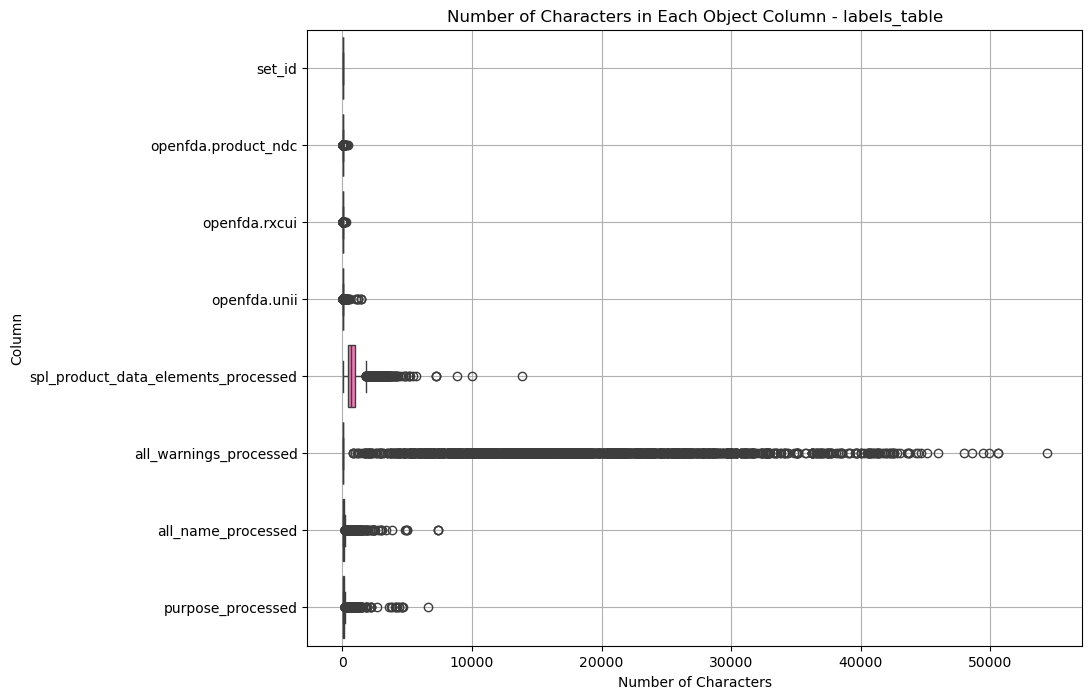


Descriptive Statistics on Character Length:
                                       count       mean          std   min  \
set_id                               10000.0    36.0000     0.000000  36.0   
openfda.product_ndc                  10000.0    10.2946    14.836483   3.0   
openfda.rxcui                        10000.0     7.0721     9.460817   3.0   
openfda.unii                         10000.0    13.9992    42.562577   3.0   
spl_product_data_elements_processed  10000.0   782.7851   623.905770   4.0   
all_warnings_processed               10000.0  3215.4059  8047.160151   3.0   
all_name_processed                   10000.0    79.5968   243.596652   3.0   
purpose_processed                    10000.0    94.0513   229.686483   4.0   

                                       25%    50%    75%      max  
set_id                                36.0   36.0   36.0     36.0  
openfda.product_ndc                    3.0    3.0   13.0    390.0  
openfda.rxcui                          3.0    3.

In [27]:
plot_character_length(labels_table, 'labels_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

In [38]:
labels_table_text_processed_outliers = examine_text_outliers(labels_table['all_warnings_processed'])
print(labels_table_text_processed_outliers.iloc[2])

['completely atrophic', 'least 25', 'history', 'ligament', 'threatening hospitalization', '62 separate', 'become', 'ipledge program', 'unprotected intercourse', 'also x', 'loan otherwise', '6', 'collection', 'device hormonal', '1088 contraindicated', 'weight appetite', 'stimulating', 'neutropenia agranulocytosis', 'determine', 'withdrawal bleeding', 'assessed', '2c9 human', 'relevant', 'pulmonary mesenteric', 'cerebri', 'unknown 20', 'ophthalmological', 'including', 'drug interaction', 'question importance', 'sjs', 'result death', 'shipping', 'laboratory test', 'lumbar spine', 'vaginal', 'alcohol 36', 'data', 'allergic', 'wort', 'language reproduction', 'parturition 0', 'signing', 'sponge control', 'metabolic activation', 'problem discussed', 'attempt order', 'using', 'automatic allowed', 'papilledema headache', 'evaluate', 'uncertain', 'hepatitis possibly', 'rectal bleeding', 'prescribers', 'licensed u', 'simultaneously continuously', 'comply', 'main', 'remain', '20 year', 'acceptable

### Rename Columns

In [190]:
labels_table = labels_table.rename(columns = {'openfda.product_ndc': 'ndc',
                                              'openfda.rxcui': 'rxcui',
                                              'openfda.unii': 'unii',
                         'spl_product_data_elements_processed': 'ingredients',
                         'all_warnings_processed': 'warnings',
                         'all_name_processed': 'drug_names',
                         'openfda.manufacturer_name_processed': 'manufacturer',
                         'purpose_processed': 'purpose'})

In [40]:
labels_table.head()

,set_id,label_id,year,ndc,rxcui,openfda.unii,ingredients,warnings,drug_names,purpose
0,0000025c-6dbf-4af7-a741-5cbacaed519a,1,2021,[15631-0404],NaN,[ETJ7Z6XBU4],"[silicea, sucrose, silicon, dioxide, silicea s...",NaN,"[silicea, dioxide, silicon, silicon dioxide]","[medical evidence, evidence fda, acne boil, cl..."
1,0000076a-fc39-4208-ace8-6c2cb367904f,2,2015,NaN,NaN,NaN,"[chantecaille, protection, naturelle, bronze, ...",NaN,NaN,"[purpose sunscreen, purpose, sunscreen]"
2,00006ebc-ec2b-406c-96b7-a3cc422e933f,3,2023,NaN,NaN,NaN,"[mezereum, daphne, bark, sucrose, lactose, whi...",NaN,NaN,"[relieve, us relieve, us, itching, relieve sym..."
3,00011703-bc55-4c0c-858c-149dc674bc3c,4,2023,NaN,NaN,NaN,"[ofloxacin, sodium, chloride, hydrochloric, ac...","[immature animal, history, enhance, young dog,...",NaN,<NA>
4,000155a8-709c-44e5-a75f-cd890f3a7caf,5,2023,[50090-0481],[198014],[57Y76R9ATQ],"[naproxen, croscarmellose, sodium, povidone, u...",NaN,[naproxen],<NA>


In [191]:
labels_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   set_id       10000 non-null  object
 1   label_id     10000 non-null  int64 
 2   year         10000 non-null  int32 
 3   ndc          4820 non-null   object
 4   rxcui        3433 non-null   object
 5   unii         4734 non-null   object
 6   ingredients  9986 non-null   object
 7   warnings     1757 non-null   object
 8   drug_names   4734 non-null   object
 9   purpose      6042 non-null   object
dtypes: int32(1), int64(1), object(8)
memory usage: 742.3+ KB


In [192]:
# Write the DataFrame to a CSV file
#labels_table.to_csv('DataLibrary/labels_table.csv', index=False)

## PreProcess Events Table

In [41]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 43 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   safetyreportid                               10000 non-null  object 
 1   transmissiondateformat                       10000 non-null  object 
 2   transmissiondate                             10000 non-null  object 
 3   serious                                      10000 non-null  object 
 4   seriousnessdeath                             706 non-null    object 
 5   receivedateformat                            10000 non-null  object 
 6   receivedate                                  10000 non-null  object 
 7   receiptdateformat                            10000 non-null  object 
 8   receiptdate                                  10000 non-null  object 
 9   fulfillexpeditecriteria                      10000 non-null  object 
 10 

#### Select Columns

In [168]:
events_table = pd.DataFrame(events_df, 
                            columns = ["safetyreportid", #case report number
                                        "transmissiondate", # date the record was created
                                        "serious", # seriousness - 1 = result in death, lifethreatening,hospital,etc. 2 = not in the above
                                        "fulfillexpeditecriteria",  # 1 - Yes, 2 - No
                                        "primarysource.qualification",  # 1-MD, 2-Pharmacist, 3-Health Prof, 4-Lawyer, 5-Consumer/NonHealth
                                        "safetyreportversion",  # Indicates updated reports, with 1 being first, and increasing numbers as new 
                                        "companynumb",  # Company making report
                                        "seriousnessdeath", # 1 = death,
                                       "seriousnessdisabling",  # 1 = disabled
                                       "seriousnessother",  # 1 = other
                                       "seriousnesshospitalization",  # 1 = hospitalized
                                       "seriousnesslifethreatening",  # 1 = life threatening
                                       "duplicate",  # Duplicate status
                                       "reportduplicate.duplicatesource",  # source of duplicate report
                                        #  "receivedateformat", #always YYYYMMDD
                                        #  "receivedate", #date report received by FDA
                                        "primarysource.reportercountry", # country of the reporter of this event
                                        "patient.patientonsetage", # age of patient when event occured
                                        "patient.patientonsetageunit",  # 801: Y, 802: M, 803: W, 804: D, 805: H 
                                        "patient.patientsex", # sex of patient. 0=unknown, 1=male, 2=female
                                        "patient.reaction", # Dictionary list - expanded as seperate table
                                        "patient.drug", # Dictionary list - expanded as separate table
                                        # "patient.patientagegroup", #1 = neonate, 2 = infant, 3=child, 4=adolescent, 5=adult, 6=elderly
                                        # "patient.patientweight", # weight in kg
                                        # "seriousnesscongentialanomali", # 1 if congenital anomaly (fetal abnormality),absent otherwise
                                        # "authoritynumb", #regulatory authority case #
                                        # "reportduplicate"
                                      ])

#### Fix Dtypes

In [169]:
events_table['transmissiondate'] = pd.to_datetime(events_table['transmissiondate'], format='%Y%m%d')

events_table['fulfillexpeditecriteria'] = events_table['fulfillexpeditecriteria'].astype(int)

events_table['duplicate'].replace({np.nan: None}, inplace=True)
events_table['duplicate'] = events_table['duplicate'].astype(pd.Int64Dtype())

events_table['primarysource.qualification'].replace({np.nan: None}, inplace=True)
events_table['primarysource.qualification'] = events_table['primarysource.qualification'].astype(pd.Int64Dtype())

events_table['patient.patientonsetage'].replace({np.nan: None}, inplace=True)
events_table['patient.patientonsetage'] = events_table['patient.patientonsetage'].astype(pd.Int64Dtype())

events_table['patient.patientonsetageunit'].replace({np.nan: None}, inplace=True)
events_table['patient.patientonsetageunit'] = events_table['patient.patientonsetageunit'].astype(pd.Int64Dtype())

events_table['patient.patientsex'].replace({np.nan: None}, inplace=True)
events_table['patient.patientsex'] = events_table['patient.patientsex'].astype(pd.Int64Dtype())

events_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   safetyreportid                   10000 non-null  object        
 1   transmissiondate                 10000 non-null  datetime64[ns]
 2   serious                          10000 non-null  object        
 3   fulfillexpeditecriteria          10000 non-null  int32         
 4   primarysource.qualification      9671 non-null   Int64         
 5   safetyreportversion              9999 non-null   object        
 6   companynumb                      9824 non-null   object        
 7   seriousnessdeath                 706 non-null    object        
 8   seriousnessdisabling             203 non-null    object        
 9   seriousnessother                 3385 non-null   object        
 10  seriousnesshospitalization       1874 non-null   object    

### Standardize Age

In [170]:
events_table['patient.patientonsetage'] = events_table.apply(lambda row: convert_to_years(row['patient.patientonsetage'], row['patient.patientonsetageunit']), axis=1)
events_table.drop(columns=['patient.patientonsetageunit'], inplace=True)
events_table.head(1)

,safetyreportid,transmissiondate,serious,fulfillexpeditecriteria,primarysource.qualification,safetyreportversion,companynumb,seriousnessdeath,seriousnessdisabling,seriousnessother,seriousnesshospitalization,seriousnesslifethreatening,duplicate,reportduplicate.duplicatesource,primarysource.reportercountry,patient.patientonsetage,patient.patientsex,patient.reaction,patient.drug
0,5801206-7,2009-01-09,1,1,3,NaN,JACAN16471,1,NaN,NaN,NaN,NaN,<NA>,NaN,CANADA,26.0,1,[{'reactionmeddrapt': 'DRUG ADMINISTRATION ERR...,"[{'drugcharacterization': '1', 'medicinalprodu..."


### Feature Engineering

In [171]:
events_table = add_sequential_index(events_table,'event_id')

#### Combining Levels of Seriousness into 3-Level Variable (death, serious, non-serious)

In [172]:
# Serious prior to mapping
events_table['serious'].value_counts()

serious
1    5358
2    4642
Name: count, dtype: int64

In [173]:
events_table['serious'] = events_table['serious'].replace({'2': '0'})

In [174]:
# Update seriousness categories into three levels
events_table['seriousnessdeath']=events_table['seriousnessdeath'].replace({'2': '0'}).fillna('0').astype(int)
events_table['seriousnessdisabling']=events_table['seriousnessdisabling'].replace({'2': '0', '1': '2'}).fillna('0').astype(int)
events_table['seriousnesshospitalization']=events_table['seriousnesshospitalization'].replace({'2': '0', '1': '3'}).fillna('0').astype(int)
events_table['seriousnesslifethreatening']=events_table['seriousnesslifethreatening'].replace({'2': '0', '1': '4'}).fillna('0').astype(int)
events_table['seriousnessother']=events_table['seriousnessother'].replace({'2': '0', '1': '5'}).fillna('0').astype(int)

In [175]:
events_table['seriousnessdeath'].value_counts()

seriousnessdeath
0    9299
1     701
Name: count, dtype: int64

In [176]:
events_table['seriousnesshospitalization'].value_counts()

seriousnesshospitalization
0    8130
3    1870
Name: count, dtype: int64

In [177]:
events_table['serious_outcome'] = events_table[['seriousnessdeath',
                                                'seriousnessdisabling',
                                                'seriousnesshospitalization',
                                                'seriousnesslifethreatening',
                                               'seriousnessother']].sum(axis=1)
events_table['serious_outcome'] = events_table['serious_outcome'].apply(lambda x: 2 if x == 1 else (0 if x == 5 else 1))

In [178]:
events_table['serious_outcome'] = events_table['serious_outcome'].replace({2: 'Death', 1: 'NonSerious', 0: 'Serious'})

In [179]:
events_table['serious_outcome'].value_counts()

serious_outcome
NonSerious    6817
Serious       2770
Death          413
Name: count, dtype: int64

In [180]:
# Convert Date to Year
#events_table['transmissiondate'] = events_table['transmissiondate'].dt.year
events_table['year'] = events_table['transmissiondate'].dt.year

### Check for Report Duplicates - openFDA return only most recent report

In [181]:
# Check for safety report # duplicates
duplicates = events_table.duplicated(subset=['safetyreportid']).sum()

print("Duplicates: ", duplicates) 

Duplicates:  0


In [182]:
events_table[['safetyreportid', 'safetyreportversion', 'duplicate', 'reportduplicate.duplicatesource']].head(5)

,safetyreportid,safetyreportversion,duplicate,reportduplicate.duplicatesource
0,5801206-7,NaN,<NA>,NaN
1,10003300,1,1,GENENTECH
2,10003301,1,1,JANSSEN
3,10003302,1,1,PFIZER
4,10003304,2,1,PFIZER


### Examine and Handle Nulls

In [135]:
events_nan = nan_info(events_table)
events_nan

,column_name,null_count,null_proportion
0,event_id,0,0.00
1,safetyreportid,0,0.00
2,transmissiondate,0,0.00
3,serious,0,0.00
4,fulfillexpeditecriteria,0,0.00
5,primarysource.qualification,329,3.29
6,safetyreportversion,1,0.01
7,companynumb,176,1.76
8,seriousnessdeath,0,0.00
9,seriousnessdisabling,0,0.00


In [183]:
sex_value_counts = events_table['patient.patientsex'].value_counts()
print(sex_value_counts)

#For sex, 0=unknown, 1=male, 2=female. fill missing values with 0.
events_table['patient.patientsex'] = events_table['patient.patientsex'].fillna(0)

patient.patientsex
2    5808
1    3195
0     923
Name: count, dtype: Int64


### Filter Events for Quality Data
* Remove events that have consumer and lawyer reports
* Verify that API called only most recent version of reports

In [184]:
# Drop NaN values in 'primarysource.qualification'
events_table.dropna(subset=['primarysource.qualification'], inplace=True)

# Convert 'primarysource.qualification' to integer
events_table['primarysource.qualification'] = events_table['primarysource.qualification'].astype(int)

# Filter out values 4 and 5
events_table = events_table[~events_table['primarysource.qualification'].isin([4, 5])]

events_table.shape

(4305, 22)

In [138]:
# Verified that version control exists in API request
events_table[['safetyreportid', 'safetyreportversion']].head(10)

,safetyreportid,safetyreportversion
0,5801206-7,NaN
4,10003304,2
5,10003305,1
7,10003307,3
8,10003308,3
13,10003313,3
17,10003317,1
18,10003318,2
22,10003322,3
24,10003324,3


### Rename Columns

In [185]:
# Rename some columns
events_table = events_table.rename(columns={
    'primarysource.reportercountry': 'country',
    'patient.patientsex': 'sex',
    'patient.patientonsetage': 'age',
    'patient.reaction': 'reaction',
    'patient.drug': 'drug',
    'transmissiondate': 'event_year',
    'fulfillexpeditecriteria': 'expedited',
    'primarysource.qualification': 'report_source',
    'companynumb': 'company'
})

In [140]:
#pd.reset_option('display.max_colwidth')
events_table.head()

,event_id,safetyreportid,event_year,serious,expedited,report_source,safetyreportversion,company,seriousnessdeath,seriousnessdisabling,...,seriousnesslifethreatening,duplicate,reportduplicate.duplicatesource,country,age,sex,reaction,drug,serious_outcome,year
0,1,5801206-7,2009-01-09,1,1,3,NaN,JACAN16471,1,0,...,0,<NA>,NaN,CANADA,26.0,1,[{'reactionmeddrapt': 'DRUG ADMINISTRATION ERR...,"[{'drugcharacterization': '1', 'medicinalprodu...",Death,2009
4,5,10003304,2014-12-12,0,2,1,2,US-PFIZER INC-2014063856,0,0,...,0,1,PFIZER,US,NaN,2,"[{'reactionmeddraversionpt': '17.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NonSerious,2014
5,6,10003305,2014-10-02,0,2,1,1,US-PFIZER INC-2014069067,0,0,...,0,1,PFIZER,US,48.0,2,"[{'reactionmeddraversionpt': '17.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NonSerious,2014
7,8,10003307,2015-11-25,0,2,1,3,US-GILEAD-2012-0058057,0,0,...,0,1,GILEAD,US,65.0,2,"[{'reactionmeddraversionpt': '18.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NonSerious,2015
8,9,10003308,2015-11-25,0,2,1,3,US-GILEAD-2012-0063316,0,0,...,0,1,GILEAD,US,59.0,2,"[{'reactionmeddraversionpt': '18.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NonSerious,2015


In [141]:
events_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4305 entries, 0 to 9985
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   event_id                         4305 non-null   int64         
 1   safetyreportid                   4305 non-null   object        
 2   event_year                       4305 non-null   datetime64[ns]
 3   serious                          4305 non-null   object        
 4   expedited                        4305 non-null   int32         
 5   report_source                    4305 non-null   int32         
 6   safetyreportversion              4304 non-null   object        
 7   company                          4212 non-null   object        
 8   seriousnessdeath                 4305 non-null   int32         
 9   seriousnessdisabling             4305 non-null   int32         
 10  seriousnessother                 4305 non-null   int32         
 

### Make new table for PatientDrugs - nested dataframe

#### Without MultiProcessing

In [186]:
start_time = time.time()

expanded_patient_drugs = []

# Iterate through each row of the original DataFrame
for _, row in events_table.iterrows():
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['drug']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_patient_drugs.append(flattened_entry)

# Concatenate all entries into a new DataFrame
patient_drugs_table = pd.concat(expanded_patient_drugs, ignore_index=True)
patient_drugs_table = patient_drugs_table[['event_id'] + [col for col in patient_drugs_table.columns if col != 'event_id']]


end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

54.25968885421753


#### With MultiProcessing

In [ ]:
start_time = time.time()
expanded_patient_drugs = []
def process_row(row):
    expanded_patient_drugs = []
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'drug' list
    for drug_entry in row['drug']:
        flattened_entry = json_normalize(drug_entry)
        flattened_entry['event_id'] = event_id
        expanded_patient_drugs.append(flattened_entry)
    
    return pd.concat(expanded_patient_drugs, ignore_index=True)

if __name__ == '__main__':
    num_cores = mp.cpu_count()  # Number of CPU cores
    with mp.Pool(num_cores) as pool:
        patient_drugs_list = pool.map(process_row, events_table.to_dict('records'))

    # Concatenate all entries into a new DataFrame
    patient_drugs_table = pd.concat(patient_drugs_list, ignore_index=True)
    patient_drugs_table = patient_drugs_table[['event_id'] + [col for col in patient_drugs_table.columns if col != 'event_id']]

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

### Make new table for PatientReactions

#### Without MultiProcessing

In [187]:
start_time = time.time()

expanded_patient_reaction = []

# Iterate through each row of the original DataFrame
for _, row in events_table.iterrows():
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['reaction']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_patient_reaction.append(flattened_entry)

# Concatenate all entries into a new DataFrame
patient_reactions_df = pd.concat(expanded_patient_reaction, ignore_index=True)
patient_reactions_df = patient_reactions_df[['event_id'] + [col for col in patient_reactions_df.columns if col != 'event_id']]

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

11.81577730178833


#### With MultiProcessing

In [ ]:
start_time = time.time()

def process_row(row):
    expanded_patient_reaction = []
    event_id = row['event_id']
    
    # Iterate through each reaction entry in 'reaction' list
    for reaction_entry in row['reaction']:
        flattened_entry = json_normalize(reaction_entry)
        flattened_entry['event_id'] = event_id
        expanded_patient_reaction.append(flattened_entry)
    
    return pd.concat(expanded_patient_reaction, ignore_index=True)

if __name__ == '__main__':
    num_cores = mp.cpu_count()  # Number of CPU cores

    with mp.Pool(num_cores) as pool:
        # Use pool.map to process each row in parallel
        patient_reactions_list = pool.map(process_row, events_table.to_dict('records'))

    # Concatenate all entries into a new DataFrame
    patient_reactions_df = pd.concat(patient_reactions_list, ignore_index=True)
    patient_reactions_df = patient_reactions_df[['event_id'] + [col for col in patient_reactions_df.columns if col != 'event_id']]
    
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

### Remove Drug and Reaction Columns as they are in new tables

In [ ]:
events_table.drop(['drug', 'reaction'], axis=1, inplace=True)

### Assess Text Field Lengths

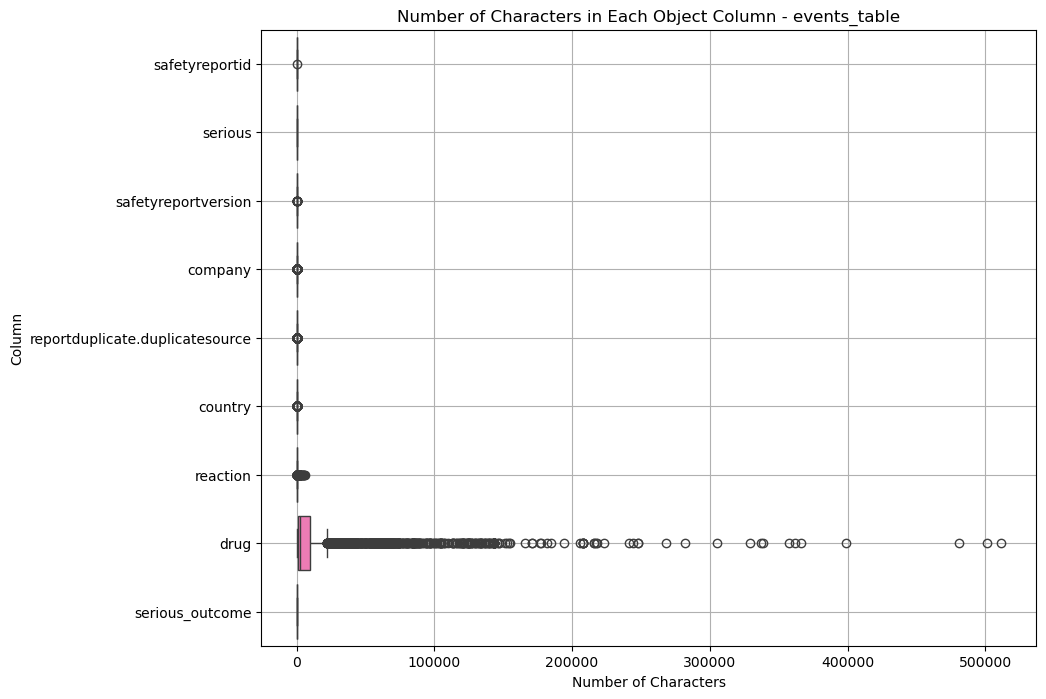


Descriptive Statistics on Character Length:
                                  count          mean           std   min  \
safetyreportid                   4305.0      8.000232      0.015241   8.0   
serious                          4305.0      1.000000      0.000000   1.0   
safetyreportversion              4305.0      1.005343      0.076026   1.0   
company                          4305.0     24.742160      8.510514   3.0   
reportduplicate.duplicatesource  4305.0      6.842973      3.065648   3.0   
country                          4305.0      2.508479      3.064439   2.0   
reaction                         4305.0    270.876423    326.683283  65.0   
drug                             4305.0  14117.212079  34662.646077  63.0   
serious_outcome                  4305.0      8.855749      1.618278   5.0   

                                    25%     50%     75%       max  
safetyreportid                      8.0     8.0     8.0       9.0  
serious                             1.0     1.0 

In [142]:
plot_character_length(events_table, 'events_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

In [143]:
events_table_text_processed_outliers = examine_text_outliers(events_table['company'])
print(events_table_text_processed_outliers.iloc[2])

US-B.I. PHARMACEUTICALS,INC./RIDGEFIELD-2014-BI-09440PF


#### Custom Text Processing of Company Information - Retain Name Only

In [193]:
# Creat list of country abbreviations and extra abbreviations to remove from text data
country_codes = events_table['country'].unique().tolist()
country_codes = [i.lower() for i in country_codes]
country_codes = ['cn' if country == 'canada' else country for country in country_codes]
country_codes = country_codes+["usa", "isr", "ger", "tus", "dklu", "bp", "sp",
                                  "nj", "aus", "deuct", "ve", "pomal", "gbr",
                                  "jacan", "fra", "deu", 'deuct', 'ita',
                              'gw', 'jet', 'aur', 'aut', 'ml',
                              'eut', 'ent', 'sp', 'chn',
                              'jpn', 'kor', 'can', 'europe',
                              'bw', 'rr', 'eu', 'bl', 'deusp',
                              'uki', 'japan', 'teu', 'ind']

extra_abv = ['nldsp', 'usasp', 'company', 'bax', 'spo',
                'ccaza', 'cinry', 'and', 'cansp', 'oxyc',
            'scpr', 'gbrct', 'gbrsp', 'tjp', 'unk',
            'frasp', 'brasp', 'sol', 'cbst','pmco',
            'jpnct', 'frua', 'espct', 'pre',
            'dsu', 'gmbh', 'dse', 'belsp', 'crisp',
            'kdl', 'irlsp', 'mpi', 'avee', 'usani', 
            'sun', 'belct', 'itasp', 'hkgsp', 'argsp']

country_codes_df = pd.DataFrame({'codes': country_codes})

# save list of country codes
country_codes_df.to_csv('DataLibrary/country_codes.csv', index=False)

##### No Multiprocessing

In [152]:
start_time = time.time() 
events_table['company_name'] = events_table['company'].astype(str).apply(process_company_text)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

6.709968328475952


##### With Multiprocessing

In [ ]:
# Create a pool with the same number of workers as CPU cores
start_time = time.time() 
if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        company_name = pool.map(process_company_text, events_table['company'])
        events_table['company_name'] = company_name
    # Apply the process_company_row function to each element in the 'company' column in parallel
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

In [153]:
events_table[['company', 'company_name', 'country']].head(20) 

,company,company_name,country
0,JACAN16471,<NA>,CANADA
4,US-PFIZER INC-2014063856,"[pfizer, inc]",US
5,US-PFIZER INC-2014069067,"[pfizer, inc]",US
7,US-GILEAD-2012-0058057,[gilead],US
8,US-GILEAD-2012-0063316,[gilead],US
13,US-GILEAD-2012-0057186,[gilead],US
17,US-GLAXOSMITHKLINE-A1057101A,[glaxosmithkline],US
18,BR-GLAXOSMITHKLINE-A1062190A,[glaxosmithkline],BR
22,US-GILEAD-2012-0057218,[gilead],US
24,US-GILEAD-2012-0058151,[gilead],US


In [154]:
# Set display option to show the full list without truncation
pd.set_option('display.max_rows', None)
events_table['company_name'].value_counts()
# Reset display option to default
#pd.reset_option('display.max_rows')

company_name
[incyte, corporation]                      853
[gilead]                                   469
[baxter]                                   367
[pubhosp]                                  243
[pfizer, inc]                              218
[jnjfoc]                                   199
[amgen]                                    173
[abbvie]                                   132
[teva]                                     112
[roche]                                    106
[glaxosmithkline]                          100
[celgeneus]                                 96
[nan]                                       93
[bayer]                                     71
[bi, pharmaceuticals]                       70
[biogenidec, bi]                            56
[actelion]                                  48
[astrazeneca]                               39
[mylanlabs]                                 39
[ranbaxy]                                   39
[astellas]                                  36


#### Text Processing of Country Name

In [155]:
# Replace category missing label with NA and Canada
events_table['country'] = events_table['country'].replace({"COUNTRY NOT SPECIFIED": pd.NA, "CANADA": 'CN'})

# Lower case country code text
events_table['country'] = events_table['country'].apply(lambda x: x.lower() if pd.notna(x) else x)

In [156]:
events_table['country'].head(20)

0       cn
4       us
5       us
7       us
8       us
13      us
17      us
18      br
22      us
24      us
26      cn
27      cn
28      es
29    <NA>
31      gb
33      us
35      us
38      it
39      us
40      cn
Name: country, dtype: object

In [157]:
# Drop Cryptic company information
events_table.drop(['company'], axis = 1, inplace = True)

In [158]:
events_table[['company_name', 'country']].head(10) 

,company_name,country
0,<NA>,cn
4,"[pfizer, inc]",us
5,"[pfizer, inc]",us
7,[gilead],us
8,[gilead],us
13,[gilead],us
17,[glaxosmithkline],us
18,[glaxosmithkline],br
22,[gilead],us
24,[gilead],us


### Reeaxmine Field Lengths

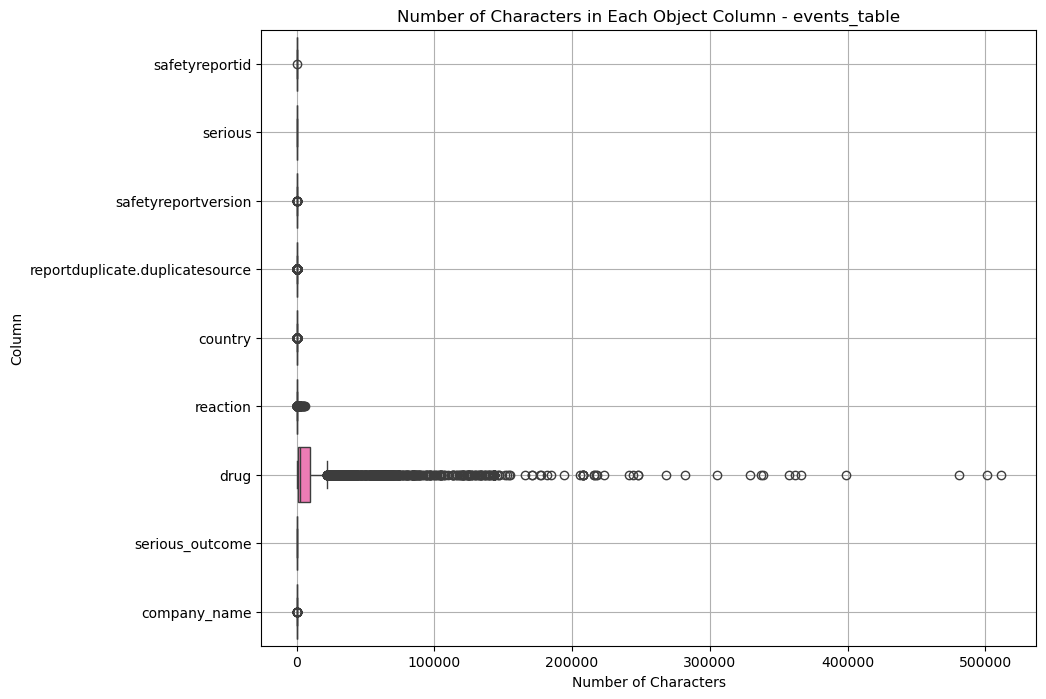


Descriptive Statistics on Character Length:
                                  count          mean           std   min  \
safetyreportid                   4305.0      8.000232      0.015241   8.0   
serious                          4305.0      1.000000      0.000000   1.0   
safetyreportversion              4305.0      1.005343      0.076026   1.0   
reportduplicate.duplicatesource  4305.0      6.842973      3.065648   3.0   
country                          4305.0      2.053426      0.322525   2.0   
reaction                         4305.0    270.876423    326.683283  65.0   
drug                             4305.0  14117.212079  34662.646077  63.0   
serious_outcome                  4305.0      8.855749      1.618278   5.0   
company_name                     4305.0     14.035772      7.285860   4.0   

                                    25%     50%     75%       max  
safetyreportid                      8.0     8.0     8.0       9.0  
serious                             1.0     1.0 

In [159]:
plot_character_length(events_table, 'events_table')

In [163]:
examine_text_outliers(events_table['company_name']).iloc[0:10]

723     [spectrum, pharmaceuticals, inc]
1703            [bristol, myers, squibb]
1706            [bristol, myers, squibb]
1710            [bristol, myers, squibb]
1714            [bristol, myers, squibb]
1716            [bristol, myers, squibb]
1756                  [emd, serono, inc]
1775         [roxane, laboratories, inc]
1841            [bristol, myers, squibb]
1903                  [emd, serono, inc]
Name: company_name, dtype: object

#### Choose Final List of Features

In [165]:
events_table = events_table[['event_id',
                            'year',
                            'expedited',
                            'report_source',
                            'country',
                            'age',
                            'sex',
                            'serious_outcome',
                            'company_name']]

In [167]:
# Write the DataFrame to a CSV file
#events_table.to_csv('DataLibrary/events_table.csv', index=False)

## PreProcess Patient Drugs Table

In [188]:
patient_drugs_table.head()
patient_drugs_table.columns

Index(['event_id', 'drugcharacterization', 'medicinalproduct',
       'drugauthorizationnumb', 'drugadministrationroute', 'drugindication',
       'drugdosagetext', 'actiondrug', 'openfda.application_number',
       'openfda.brand_name', 'openfda.generic_name',
       'openfda.manufacturer_name', 'openfda.product_ndc',
       'openfda.product_type', 'openfda.route', 'openfda.substance_name',
       'openfda.rxcui', 'openfda.spl_id', 'openfda.spl_set_id',
       'openfda.package_ndc', 'openfda.unii', 'openfda.nui',
       'openfda.pharm_class_epc', 'openfda.pharm_class_cs', 'drugdosageform',
       'openfda.pharm_class_moa', 'openfda.pharm_class_pe',
       'drugstructuredosagenumb', 'drugstructuredosageunit',
       'drugstartdateformat', 'drugstartdate',
       'activesubstance.activesubstancename', 'drugrecurreadministration',
       'drugenddateformat', 'drugenddate', 'drugbatchnumb',
       'drugseparatedosagenumb', 'drugintervaldosageunitnumb',
       'drugintervaldosagedefinition

#### Select Columns

In [194]:
patient_drugs_table = pd.DataFrame(patient_drugs_table, 
                               columns = [
                                'event_id',  # Identifier for the event
                                'drugcharacterization',  # Level of detail for the drug in the event report
                                'medicinalproduct',  # Name of the drug
                                # 'drugauthorizationnumb',  # Marketing authorization number of the drug
                                # 'drugadministrationroute',  # Route of administration for the drug
                                'drugindication',  # Indication for use of the drug
                                # 'drugbatchnumb',  # Batch number for the drug
                                # 'drugstructuredosagenumb',  # Structured dosage number of the drug
                                # 'drugstructuredosageunit',  # Unit of structured dosage for the drug
                                # 'drugdosagetext',  # Textual description of the dosage for the drug
                                # 'drugstartdateformat',  # Date format for the start date of drug administration
                                # 'drugstartdate',  # Start date of drug administration
                                #'drugrecurreadministration',  # Indicator for recurring drug administration
                                # 'drugadditional',  # Additional details about the drug
                                # 'openfda.application_number',  # FDA application number for the drug
                                # 'openfda.brand_name',  # Brand name for the drug
                                'openfda.generic_name',  # Generic name for the drug
                                'openfda.manufacturer_name',  # Manufacturer name for the drug
                                #'openfda.product_ndc',  # NDC (National Drug Code) number for the drug product
                                'openfda.product_type',  # Type of drug product (e.g., HUMAN PRESCRIPTION DRUG)
                                # 'openfda.route',  # Route of administration for the drug
                                # 'openfda.substance_name',  # Substance name associated with the drug
                                'openfda.rxcui',  # RxNorm Concept Unique Identifier (RxCUI) for the drug
                                # 'openfda.spl_id',  # Structured Product Labeling (SPL) ID for the drug
                                'openfda.spl_set_id',  # SPL Set ID for the drug
                                # 'openfda.package_ndc',  # NDC (National Drug Code) number for the drug package
                                # 'openfda.nui',  # NUI (National Uniform Identifier) for the drug
                                # 'openfda.pharm_class_moa',  # Pharmacological class (Mechanism of Action) for the drug
                                # 'openfda.pharm_class_cs',  # Chemical structure class for the drug
                                # 'openfda.pharm_class_epc',  # Pharmacological class (EPC) for the drug
                                'openfda.unii',  # Unique Ingredient Identifier (UNII) for the drug substance
                                # 'actiondrug',  # Action taken with the drug
                                # 'drugdosageform',  # Dosage form of the drug
                                # 'openfda.pharm_class_pe',  # Pharmacological class (Physiologic Effect) for the drug
                                # 'activesubstance.activesubstancename',  # Name of the active substance in the drug
                                # 'drugenddateformat',  # Date format for the end date of drug administration
                                # 'drugenddate',  # End date of drug administration
                                #'drugseparatedosagenumb',  # Separated dosage number for the drug
                                # 'drugintervaldosageunitnumb',  # Interval dosage unit number for the drug
                                # 'drugintervaldosagedefinition',  # Definition of interval dosage for the drug
                                # 'drugcumulativedosagenumb',  # Cumulative dosage number for the drug
                                # 'drugcumulativedosageunit'  # Unit of cumulative dosage for the drug
                            ])


In [195]:
patient_drugs_table.head(5)

,event_id,drugcharacterization,medicinalproduct,drugindication,openfda.generic_name,openfda.manufacturer_name,openfda.product_type,openfda.rxcui,openfda.spl_set_id,openfda.unii
0,1,1,DURAGESIC-100,DRUG ABUSE,NaN,NaN,NaN,NaN,NaN,NaN
1,5,1,DOXYCYCLINE HYCLATE,NaN,"[DOXYCYCLINE HYCLATE, DOXYCYCLINE, DOXYCLYCLIN...","[Mayne Pharma Commercial LLC, Actavis Pharma, ...",[HUMAN PRESCRIPTION DRUG],"[1653433, 2122343, 1650143, 1652674, 283535, 4...","[f9c63af9-d613-43fc-b8e5-ab6219f24c70, a569ba8...","[19XTS3T51U, N12000U13O, 8ZL07I20SB]"
2,5,1,TRAMADOL HYDROCHLORIDE,NaN,[TRAMADOL HYDROCHLORIDE],"[Amneal Pharmaceuticals NY LLC, Zydus Pharmace...",[HUMAN PRESCRIPTION DRUG],"[835603, 2395808, 833709, 833711, 833713, 1148...","[8ec4e4e5-a56e-4198-8428-6b770b9bf27d, ee7179b...",[9N7R477WCK]
3,5,1,OXYCONTIN,NaN,[OXYCODONE HYDROCHLORIDE],[Purdue Pharma LP],[HUMAN PRESCRIPTION DRUG],"[1049504, 1049545, 1049565, 1049576, 1049586, ...",[bfdfe235-d717-4855-a3c8-a13d26dadede],[C1ENJ2TE6C]
4,5,1,TALWIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Fix Dtypes

In [196]:
patient_drugs_table['drugcharacterization'] = patient_drugs_table['drugcharacterization'].astype(int)

#### Filter for Quality Data

In [197]:
patient_drugs_table['drugcharacterization'].value_counts()

drugcharacterization
2    8561
1    7779
3     136
Name: count, dtype: int64

In [198]:
# Add unique ID
patient_drugs_table = add_sequential_index(patient_drugs_table,'patient_drug_id')

# Keep only primary drug suspects
patient_drugs_table = patient_drugs_table.loc[patient_drugs_table['drugcharacterization'] == 1]

#### Examining Variables of Interest
* Drugcharacterization: 1-suspect(drug primary cause), 2-concomitant(drug taken with primary cause), 3-interation(drug interact with primary cause)
* Medicinalproduct: generic or brand name
* Drugindication: official drug purpose
* openfda.rxcui : Rx cui code
* openfda.unii : unique ingredient identifier

In [199]:
patient_drugs_table['drugcharacterization'].value_counts()

drugcharacterization
1    7779
Name: count, dtype: int64

### Examine Nulls

In [200]:
patient_drugs_table_nan_info = nan_info(patient_drugs_table)
patient_drugs_table_nan_info

,column_name,null_count,null_proportion
0,patient_drug_id,0,0.000000
1,event_id,0,0.000000
2,drugcharacterization,0,0.000000
3,medicinalproduct,0,0.000000
4,drugindication,1930,24.810387
5,openfda.generic_name,1930,24.810387
6,openfda.manufacturer_name,1930,24.810387
7,openfda.product_type,1930,24.810387
8,openfda.rxcui,2025,26.031624
9,openfda.spl_set_id,1930,24.810387


### Text Processing

#### Without MultiProcessing

In [201]:
# Apply the clean_text function
start_time = time.time()

patient_drugs_table['manu_list'] = patient_drugs_table['openfda.manufacturer_name'].apply(clean_manufacturer_text)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

0.7111263275146484


#### With MultiProcessing

In [ ]:
start_time = time.time()
if __name__ == '__main__':    
    with mp.Pool(num_cores) as pool:
        # Use pool.map to apply clean_manufacturer_text to each element in parallel
        patient_drugs_table['manu_list'] = pool.map(clean_manufacturer_text, patient_drugs_table['openfda.manufacturer_name'])
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

In [202]:
# Count the number of manufacturers that produce the drug
patient_drugs_table['manu_num'] = patient_drugs_table['manu_list'].apply(lambda x: len(x) if np.all(pd.notna(x))==True else 0)

In [203]:
# Count the number of rxcui associated with drug
patient_drugs_table['rxcui_num'] = patient_drugs_table['openfda.rxcui'].apply(lambda x: len(x) if np.all(pd.notna(x))==True else 0)

In [204]:
patient_drugs_table[['openfda.manufacturer_name', 'manu_list', 'manu_num', 'rxcui_num']].head(10)

,openfda.manufacturer_name,manu_list,manu_num,rxcui_num
0,NaN,<NA>,0,0
1,"[Mayne Pharma Commercial LLC, Actavis Pharma, ...","[mayne-pharma-commercial-, actavis-pharma, jg-...",31,31
2,"[Amneal Pharmaceuticals NY LLC, Zydus Pharmace...","[amneal-pharmaceuticals-ny-, zydus-pharmaceuti...",18,17
3,[Purdue Pharma LP],[purdue-pharma-lp],1,14
4,NaN,<NA>,0,0
5,[Remedy Makers],[remedy-makers],1,0
6,"[United Natural Foods, Inc. dba UNFI, Boiron, ...","[united-natural-foods, -dba-unfi, boiron, jci-...",8,1
7,"[Unifirst First Aid Corporation, Topco Associa...","[unifirst-first-aid-corporation, topco-associa...",156,25
8,NaN,<NA>,0,0
9,NaN,<NA>,0,0


### Cleaning Text Columns

In [205]:
# Define text columns
object_columns = patient_drugs_table.select_dtypes(include=['object']).columns

# Exclude columns that should not be tokenized, index codes
object_columns = object_columns.drop(['openfda.unii', 
                                      'openfda.rxcui', 
                                      'openfda.manufacturer_name', 
                                      'manu_list',
                                     'openfda.spl_set_id'], errors='ignore')
patient_drugs_table[object_columns] = patient_drugs_table[object_columns].astype(str)

#### No multiprocessing

In [206]:
# Apply the clean_text function
start_time = time.time()

for col in object_columns:
            new_col_name = col + '_processed'
            # Use pool.map to apply process_label_text to each column in parallel
            patient_drugs_table[new_col_name] = patient_drugs_table[col].apply(process_label_text)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

16.696895599365234


#### Use multiprocessing to process text columns

In [ ]:
# Apply text processing to the selected text columns and add new processed columns to dataframe
# Create a pool with the same number of workers as CPU cores

if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        for col in object_columns:
            new_col_name = col + '_processed'
            # Use pool.map to apply process_label_text to each column in parallel
            patient_drugs_table[new_col_name] = pool.map(process_label_text, patient_drugs_table[col])


### Final list of features for Patient Drugs Table

In [208]:
patient_drugs_table = patient_drugs_table[['patient_drug_id',
                                          'event_id',
                                           'openfda.spl_set_id',
                                          #'drugcharacterization',  # Not necessary since table is filtered to value of 1 for all
                                          'drugindication_processed',
                                          'medicinalproduct_processed',
                                          'openfda.generic_name_processed',
                                          'manu_list',
                                          'manu_num',
                                          'openfda.product_type_processed',
                                          'openfda.rxcui',
                                           'rxcui_num',
                                          'openfda.unii'
                                          ]]

### Rename Columns

In [209]:
patient_drugs_table = patient_drugs_table.rename(columns={
    'medicinalproduct_processed': 'med_product',
    'drugindication_processed': 'indication',
    'openfda.generic_name_processed': 'generic_name',
    'manu_list': 'manufacturers',
    'openfda.product_type_processed': 'product_type',
    'openfda.rxcui': 'rxcui',
    'openfda.unii': 'unii',
    'openfda.spl_set_id': 'spl_set_id'
})

In [210]:
patient_drugs_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7779 entries, 0 to 16475
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_drug_id  7779 non-null   int64 
 1   event_id         7779 non-null   int64 
 2   spl_set_id       5849 non-null   object
 3   indication       5849 non-null   object
 4   med_product      7779 non-null   object
 5   generic_name     5849 non-null   object
 6   manufacturers    5849 non-null   object
 7   manu_num         7779 non-null   int64 
 8   product_type     5849 non-null   object
 9   rxcui            5754 non-null   object
 10  rxcui_num        7779 non-null   int64 
 11  unii             5686 non-null   object
dtypes: int64(4), object(8)
memory usage: 790.1+ KB


### Assess Text Field Lengths

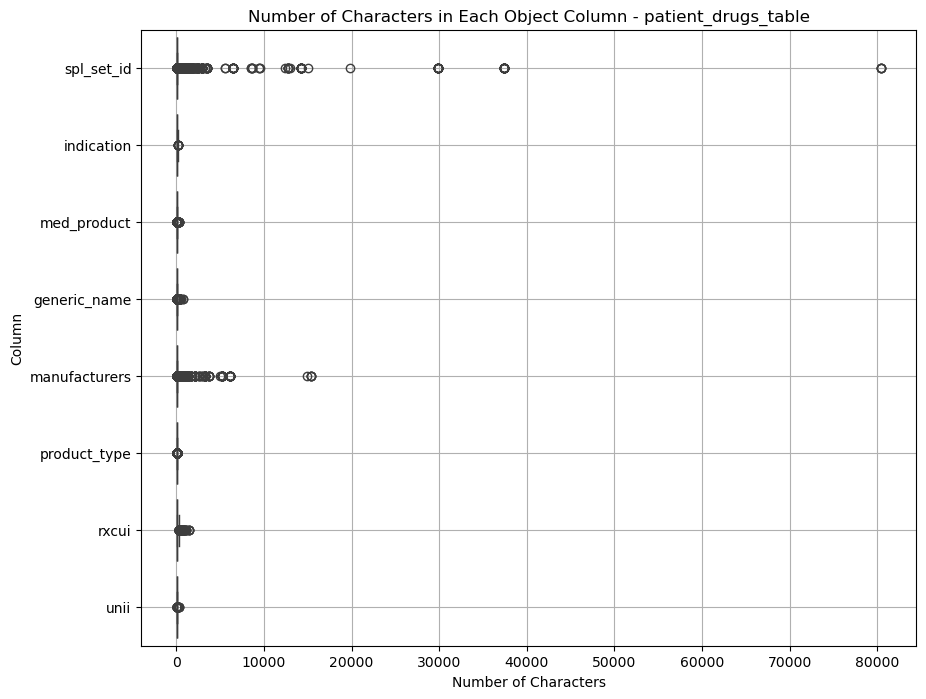


Descriptive Statistics on Character Length:
                count        mean          std  min   25%   50%    75%  \
spl_set_id     7779.0  405.567554  3048.955194  3.0  40.0  40.0   40.0   
indication     7779.0   39.155676    34.430701  4.0   8.0  29.0   60.0   
med_product    7779.0   20.691091    23.345705  7.0  11.0  12.0   15.0   
generic_name   7779.0   22.622059    33.224636  4.0  11.0  15.0   16.0   
manufacturers  7779.0  124.150919   604.099136  4.0   7.0  22.0   31.0   
product_type   7779.0   58.166217    31.243645  4.0  49.0  76.0   76.0   
rxcui          7779.0   76.679136   107.272622  3.0   3.0  41.0  110.0   
unii           7779.0   12.273171    10.070799  3.0   3.0  14.0   14.0   

                   max  
spl_set_id     80440.0  
indication       206.0  
med_product      262.0  
generic_name     693.0  
manufacturers  15333.0  
product_type      95.0  
rxcui           1461.0  
unii             336.0  


In [211]:
plot_character_length(patient_drugs_table, 'patient_drugs_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

**Examine 'Manufacturer' Outliers**
Reports contain manufacturers, distributors, and retail

In [212]:
patient_drugs_table_manufacturer_outliers = examine_text_outliers(patient_drugs_table['manufacturers'])
print(patient_drugs_table_manufacturer_outliers.iloc[2])

['amazon-com-services-', 'meijer', 'hart-health', 'major-pharmaceuticals', 'randob-labs', 'ltd-dba-crossingwell-consumer-health', 'lil-drug-store-products', 'l-n-k-international', 'amerisource-bergen', 'walmart-see-also-equate-', 'walgreen-company', 'strategic-sourcing-services-', 'kroger-company', 'aptapharma-', 'topco-associates-', 'safeway', 'p-l-development', 'granules-usa', 'advance-pharmaceutical-', 'meijer-distribution-', 'family-dollar-services-', 'johnson-johnson-consumer-', 'genexa-', 'h-e-b', 'spirit-pharmaceuticals-', 'walgreens', 'lidl-us-', 'chain-drug-consortium', 'kroger-company', 'productos-zapotol-corp-', 'northstar-rxllc', 'valu-merchandisers-company', 'gelpharma-s-a-de-c-v-', 'target-corporation', 'heb', 'magno-humphries', 'cvs-pharmacy', 'new-world-imports', 'pai-holdings', 'chain-drug-marketing-association', 'cardinal-health-110', '-dba-leader', 'discount-drug-mart', 'walgreens', 'united-natural-foods', '-dba-unfi', 'american-health-packaging', 'time-cap-laborator

**Examine 'rxcui' outliers**

In [ ]:
patient_drugs_table_rxcui_outliers = examine_text_outliers(patient_drugs_table['rxcui'])
print(patient_drugs_table_rxcui_outliers.iloc[1])

In [213]:
# Write the DataFrame to a CSV file
#patient_drugs_table.to_csv('DataLibrary/drugs_table.csv', index=False)

## PreProcess Patient Reactions Table

### Rename Columns

In [214]:
patient_reactions_table = patient_reactions_df.rename(columns={
    'reactionmeddrapt': 'reaction',
    'reactionmeddraversionpt': 'version_medDRA',
    'reactionoutcome': 'outcome'
})

### Fix Dtypes

In [ ]:
#n/a
#patient_reactions_table.head(10)
#patient_reactions_table.info()

### Feature Engineering

In [215]:
patient_reactions_table = add_sequential_index(patient_reactions_table,'patient_reaction_id')

### Map Features

In [216]:
#map outcomes to text categories

outcome_mapping = {
    1: 'Recovered',
    2: 'Recovering',
    3: 'NotRecovered',
    4: 'RecoveredWithSequelae',
    5: 'Fatal',
    6: 'Unknown'
}

# if outcome is 'Unknown', change to 6 (which will map to unknown again). Necessary that this column is int for mapping
patient_reactions_table.loc[patient_reactions_table['outcome'] == 'Unknown', 'outcome'] = 6

# Perform mapping by outcome mapping
patient_reactions_table['outcome'] = patient_reactions_table['outcome'].fillna(0).astype(int).map(outcome_mapping)

patient_reactions_table.tail()

,patient_reaction_id,event_id,reaction,version_medDRA,outcome
11857,11858,9974,Palpitations,17.0,Unknown
11858,11859,9976,Blood pressure increased,17.0,Unknown
11859,11860,9979,Drug hypersensitivity,17.0,Unknown
11860,11861,9979,Drug ineffective,17.0,Unknown
11861,11862,9986,Drug hypersensitivity,22.0,Unknown


## LIST OF UNIQUE REACTIONS

In [ ]:
# Get unique values from the 'reaction' column
unique_reactions = patient_reactions_table['reaction'].unique().tolist()
unique_reactions = [reaction.lower() for reaction in unique_reactions]

# Display unique values
#print(unique_reactions)



### Save each reaction as binary column

In [ ]:
for reaction in unique_reactions:
    patient_reactions_table[reaction] = 0

# Set the value to 1 if 'reaction' matches the column name
for idx, row in patient_reactions_table.iterrows():
    patient_reactions_table.loc[idx, reaction] = 1

patient_reactions_table.head()

In [ ]:
patient_reactions_table.shape

### Text Processing

#### Without MultiProcessing

In [217]:
#patient_reactions_table['reaction_processed'] = patient_reactions_table['reaction'].apply(process_label_text)
patient_reactions_table['reaction_processed'] = patient_reactions_table['reaction'].apply(process_label_text)

#### With MultiProcessing

In [ ]:
if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        patient_reactions_table['reaction_processed'] = pool.map(process_label_text, patient_reactions_table['reaction'])

#### Drop unprocessed reaction columns

In [218]:
patient_reactions_table = patient_reactions_table.drop('reaction', axis = 1)

### Examine Nulls

In [219]:
patient_reactions_table_nan_info = nan_info(patient_reactions_table)
patient_reactions_table_nan_info

#fill the missing values in the outcome table with 'Unknown'
patient_reactions_table['outcome'] = patient_reactions_table['outcome'].fillna('Unknown')

patient_reactions_table_nan_info = nan_info(patient_reactions_table)
patient_reactions_table_nan_info


,column_name,null_count,null_proportion
0,patient_reaction_id,0,0.000000
1,event_id,0,0.000000
2,version_medDRA,2,0.016861
3,outcome,0,0.000000
4,reaction_processed,0,0.000000


### Filter for Data Quality

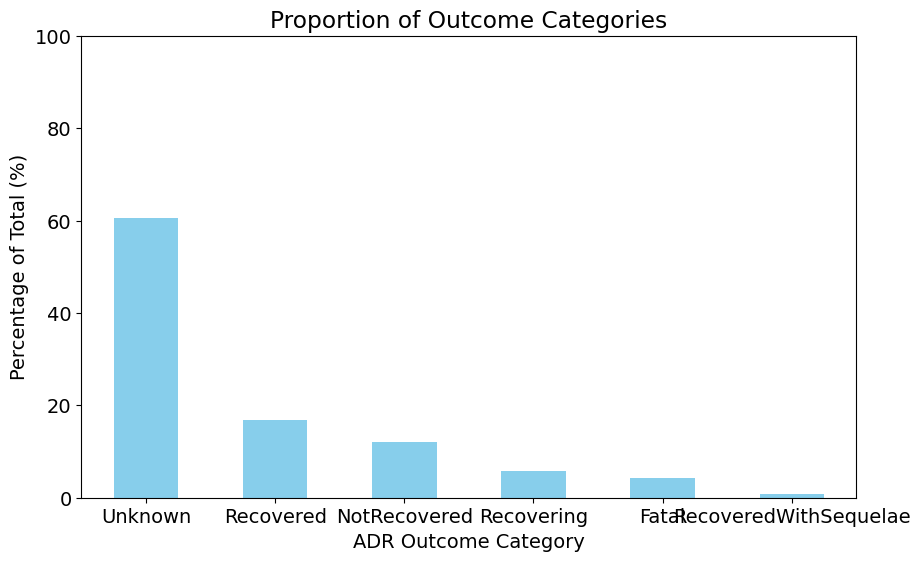

In [221]:
# Count the frequency of each category
category_counts = patient_reactions_table['outcome'].value_counts()

# Calculate the percentages
total = len(patient_reactions_table)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Outcome Categories')
plt.xlabel('ADR Outcome Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)

plt.show()

In [224]:
patient_reactions_table['outcome'].value_counts()

outcome
Unknown                  7173
Recovered                1984
NotRecovered             1425
Recovering                695
Fatal                     494
RecoveredWithSequelae      91
Name: count, dtype: int64

In [225]:
patient_reactions_table['outcome'].value_counts(normalize=True)

outcome
Unknown                  0.604704
Recovered                0.167257
NotRecovered             0.120132
Recovering               0.058590
Fatal                    0.041646
RecoveredWithSequelae    0.007672
Name: proportion, dtype: float64

In [226]:
# Drop cases with "unknown" outcomes
patient_reactions_table = patient_reactions_table.loc[patient_reactions_table['outcome'] != 'Unknown']

### Assess Text Field Lengths

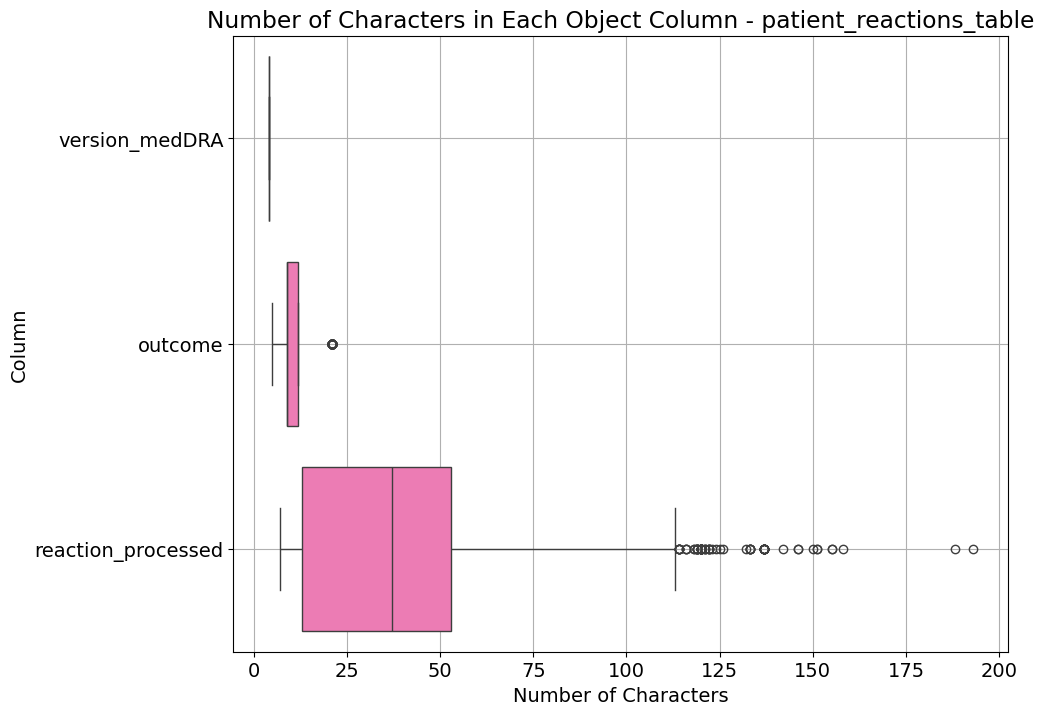


Descriptive Statistics on Character Length:
                     count       mean        std  min   25%   50%   75%    max
version_medDRA      4689.0   4.000000   0.000000  4.0   4.0   4.0   4.0    4.0
outcome             4689.0   9.871401   2.570153  5.0   9.0   9.0  12.0   21.0
reaction_processed  4689.0  37.580294  27.935002  7.0  13.0  37.0  53.0  193.0


In [227]:
plot_character_length(patient_reactions_table, 'patient_reactions_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

In [228]:
reactions_table_text_processed_outliers = examine_text_outliers(patient_reactions_table['reaction_processed'])
print(reactions_table_text_processed_outliers)

12       [tuberculosis, central, nervous, system, tuber...
29       [palmar, plantar, erythrodysaesthesia, syndrom...
43       [c, reactive, protein, increased, c reactive, ...
47       [c, reactive, protein, increased, c reactive, ...
66       [liver, function, test, abnormal, liver functi...
71       [international, normalised, ratio, increased, ...
74       [posterior, reversible, encephalopathy, syndro...
196      [acute, graft, versus, host, disease, acute gr...
197      [chronic, graft, versus, host, disease, chroni...
277      [b, lymphocyte, count, decreased, b lymphocyte...
279      [mean, platelet, volume, decreased, mean plate...
281      [white, blood, cell, count, decreased, white b...
318      [atrioventricular, block, first, degree, atrio...
339      [acute, respiratory, distress, syndrome, acute...
366      [white, blood, cell, count, increased, white b...
378      [bundle, branch, block, right, bundle branch, ...
404      [chronic, obstructive, pulmonary, disease, chr.

In [229]:
# Write the DataFrame to a CSV file
#patient_reactions_table.to_csv('DataLibrary/reactions_table.csv', index=False)

## PreProcess Prices Table

### Select Columns

In [231]:
prices_table = pd.DataFrame(prices_df, 
                            columns = [#"NDC Description",  # Identifies the drug name/dosage, Redundant Information with labels_table
                                       "NDC",  # 11 character FDA code, Do NOT Tokenize, database key
                                       "NADAC_Per_Unit",  #  The National Average Drug Acquisition Cost per unit, do NOT tokenize
                                       "Effective Date",  # The effective date of the NADAC Per Unit cost
                                        #"Pricing_Unit",  # Pricing unit for NDC ('ML', 'GM 'or 'EA'), Not necessary, just use price
                                        #"Pharmacy_Type_Indicator",  # 'C/I' data from Chain/Independent pharmacies, does not provide helpful info
                                        #"OTC",  # Indicates whether NDC is over-the-counter (OTC), redundant with labels_table
                                        #"Explanation Code",  # NADAC Calculation Method, not necessary for this project, too much missing data
                                                                       # Code 1: Inform from most recent survey.
                                                                       # Code 2: Cost within ± 2%, carried forward from previous
                                                                       # Code 3: Published pricing, or help desk inquiry
                                                                       # Code 4: Carried forward from previous year
                                                                       # Code 5: Based on package size.
                                                                       # Code 6: CMS Covered Outpatient Drug Product File drug category 
                                        "Classification_for_Rate_Setting",  # B: brand, 
                                                                            # G: generic
                                                                            # B-ANDA: brand under ANDA
                                                                            # B-BIO: biosimilar brand  
                                        #"Corresponding_Generic_Drug_NADAC_Per_Unit",
                                        #"Corresponding_Generic_Drug_Effective_Date"
                                        #"As of Date"
                                      ])

#prices_table = prices_table[['NDC', 'NADAC_Per_Unit', 'Effective Date', 'Classification_for_Rate_Setting', 
#                             'Corresponding_Generic_Drug_NADAC_Per_Unit', 'Corresponding_Generic_Drug_Effective_Date']]


### Fix Dtypes

In [232]:
prices_table['Effective Date'] = pd.to_datetime(prices_table['Effective Date'])
prices_table['year'] = prices_table['Effective Date'].dt.year
#prices_table['Corresponding_Generic_Drug_Effective_Date'] = pd.to_datetime(prices_table['Corresponding_Generic_Drug_Effective_Date'])
prices_table['NADAC_Per_Unit'] = prices_table['NADAC_Per_Unit'].astype(float)

### Examine Nulls

In [233]:
# replace empty strings with nan
prices_table = prices_table.replace(r'^\s*$', np.nan, regex=True)

prices_nan = nan_info(prices_table)
prices_nan

,column_name,null_count,null_proportion
0,NDC,0,0.0
1,NADAC_Per_Unit,0,0.0
2,Effective Date,0,0.0
3,Classification_for_Rate_Setting,0,0.0
4,year,0,0.0


### Feature Engineering 

In [234]:
prices_table['Classification_for_Rate_Setting'].value_counts()

Classification_for_Rate_Setting
G         9453
B          524
B-ANDA      23
Name: count, dtype: int64

In [235]:
# Update classification to binary generic/brand, G:1 B:0
prices_table['Classification_for_Rate_Setting'] = prices_table['Classification_for_Rate_Setting'].apply(lambda x: 1 if x == 'G' else 0)

In [236]:
# Add index column
prices_table = add_sequential_index(prices_table, 'price_id')

### Rename Columns

In [237]:
prices_table = prices_table.rename(columns = {'NDC': 'ndc',
                         'NADAC_Per_Unit': 'unit_price',
                         'Effective Date': 'price_date',
                         'Classification_for_Rate_Setting': 'generic_brand',
                         'Corresponding_Generic_Drug_NADAC_Per_Unit': 'generic_price',
                         'Corresponding_Generic_Drug_Effective_Date': 'generic_date'})

In [238]:
prices_table = prices_table[['ndc',
                            'unit_price',
                            'year',
                            'generic_brand']]

In [239]:
prices_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ndc            10000 non-null  object 
 1   unit_price     10000 non-null  float64
 2   year           10000 non-null  int32  
 3   generic_brand  10000 non-null  int64  
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 273.6+ KB


In [240]:
# Write the DataFrame to a CSV file
#prices_table.to_csv('DataLibrary/prices_table.csv', index=False)

## Preprocess Documents Table

### Select Columns

In [241]:
documents_table = pd.DataFrame(documents_df, columns=["doc_type", "year", "text"])

documents_table = add_sequential_index(documents_table,'doc_id')


### Fix Dtypes

### Match Drugs Present in Text

In [242]:
def find_matching_drugs(text, unique_drug_names):
    matched_drugs = []
    for drug in unique_drug_names:
        if drug.lower() in text.lower():
            matched_drugs.append(drug)
    return matched_drugs


#### Without MultiProcessing

In [243]:
start_time = time.time()
# Create 'matching_drugs' column using apply
documents_table['matching_drugs'] = documents_table['text'].apply(lambda x: find_matching_drugs(x, unique_drug_names))

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

NameError: name 'unique_drug_names' is not defined

#### With MultiProcessing

In [ ]:
# Figure out how to apply
# Create a pool with the same number of workers as CPU cores

start_time = time.time()


if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        documents_table['matching_drugs'] = pool.starmap(find_matching_drugs, zip(documents_table['text'], [unique_drug_names]*len(documents_table)))

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

### Match Reactions Present in Text

In [ ]:
# Function to check for matches between text and unique_reactions
def check_reactions(text, unique_reactions):
    text_lower = text.lower()
    matches = [1 if reaction.lower() in text_lower else 0 for reaction in unique_reactions]
    return matches

In [ ]:
documents_table.head()

### Generate binary column for each reaction

In [ ]:
# Apply the function across the dataframe to populate binary columns
documents_table[unique_reactions] = documents_table['text'].apply(lambda x: pd.Series(check_reactions(x, unique_reactions)))

# Text column no longer needed
documents_table.drop(columns=['text'], inplace=True)

# Function to return matching reactions as a list
def get_matching_reactions(row, unique_reactions):
    matching_reactions = [reaction for reaction in unique_reactions if row[reaction] == 1]
    return matching_reactions

# Create 'all_reactions' column by applying the function row-wise
documents_table['all_reactions'] = documents_table.apply(lambda row: get_matching_reactions(row, unique_reactions), axis=1)

documents_table.head()

In [ ]:
# apply parallel processing

### Explode Table by Reaction 

In [ ]:
# Explode the dataframe based on reaction; makes a new row for each reaction in the list
documents_table = documents_table.explode('matching_drugs').reset_index(drop=True)

### Rename columns

In [ ]:
documents_table.rename(columns={'matching_drugs': 'drug'}, inplace=True)
documents_table.head()

### Fix Dtypes

In [ ]:
numeric_columns = documents_table.drop(columns=['doc_id', 'doc_type', 'year', 'drug'])
numeric_columns = numeric_columns.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coerce errors to NaN

In [ ]:
documents_table.dtypes

### Drop all reactions column

In [ ]:
documents_table.drop(columns=['all_reactions'], inplace=True)


### Add new additional id column

In [ ]:
documents_table.head()
documents_table = add_sequential_index(documents_table, 'id')

### Save as CSV for Data Exploration

In [ ]:
documents_table.to_csv('documents_table.csv', index=False)


## Preprocess Manufacturers Table

In [244]:
manus_df.columns

Index(['product_ndc', 'generic_name', 'labeler_name', 'brand_name',
       'active_ingredients', 'finished', 'packaging',
       'listing_expiration_date', 'marketing_category', 'dosage_form',
       'spl_id', 'product_type', 'route', 'marketing_start_date', 'product_id',
       'application_number', 'brand_name_base', 'openfda.manufacturer_name',
       'openfda.spl_set_id', 'openfda.is_original_packager', 'openfda.unii',
       'openfda.rxcui', 'pharm_class', 'openfda.upc', 'openfda.nui',
       'openfda.pharm_class_moa', 'openfda.pharm_class_cs',
       'openfda.pharm_class_epc', 'dea_schedule', 'marketing_end_date',
       'openfda.pharm_class_pe', 'brand_name_suffix'],
      dtype='object')

### Select Columns

In [381]:
# Choose values to help fill in missing data from other tables
manus_table = pd.DataFrame(manus_df, 
                           columns=["product_ndc",
                                    "generic_name",
                                    "brand_name",
                                    "openfda.manufacturer_name",
                                   "spl_id",
                                   "openfda.spl_set_id",
                                   "openfda.unii",
                                   "marketing_start_date"])

### Feature Engineering

In [382]:
manus_table = add_sequential_index(manus_table,'manu_id')

In [383]:
manus_table['year'] = pd.to_datetime(manus_table['marketing_start_date']).dt.year

### Examine Nulls

In [384]:
manus_nan = nan_info(manus_table)
manus_nan

,column_name,null_count,null_proportion
0,manu_id,0,0.000000
1,product_ndc,0,0.000000
2,generic_name,0,0.000000
3,brand_name,3878,14.915385
4,openfda.manufacturer_name,4501,17.311538
5,spl_id,0,0.000000
6,openfda.spl_set_id,4501,17.311538
7,openfda.unii,4878,18.761538
8,marketing_start_date,0,0.000000
9,year,0,0.000000


### Fix Dtypes

### Text Processing

In [385]:
manus_table['drug_names'] = manus_table['generic_name']+ " " + manus_table['brand_name']

In [386]:
manus_table['drug_names_processed'] = manus_table['drug_names'].apply(process_label_text).apply(remove_duplicates_nan)
manus_table[['drug_names', 'drug_names_processed']].head(10)

,drug_names,drug_names_processed
0,Ethyl Alcohol Hand Sanitizer,"[alcohol hand, sanitizer, alcohol, hand saniti..."
1,"acetaminophen, dextromethorphan HBr, doxylamin...","[hcl severe, cold flu, dextromethorphan, guaif..."
2,IBUPROFEN IBUPROFEN,[ibuprofen]
3,Loratadine childrens allergy relief,"[loratadine childrens, childrens allergy, chil..."
4,HYDROCORTISONE Rite Aid Anti-itch,"[aid anti, aid, itch, rite, hydrocortisone rit..."
5,"DAY -ACETAMINOPHEN, DEXTROMETHORHAN HBR, PHENY...","[cold flu, strength cold, acetaminophen dextro..."
6,phenobarbital Phenobarbital,[phenobarbital]
7,Fluoxetine Fluoxetine,[fluoxetine]
8,"Octinoxate, Zinc Oxide LBEL FOREVER ULTRA MATT...","[lbel, shine, foundation, oxide lbel, lbel for..."
9,IRINOTECAN HYDROCHLORIDE Onivyde,"[irinotecan hydrochloride, onivyde, hydrochlor..."


In [387]:
manus_table['manufacturers'] = manus_table['openfda.manufacturer_name'].apply(clean_manufacturer_text)
manus_table[['openfda.manufacturer_name', 'manufacturers']].head(10)

,openfda.manufacturer_name,manufacturers
0,[Target Corp],[target-]
1,[Target Corporation],[target-corporation]
2,[TARGET CORPORATION],[target-corporation]
3,[Rite Aid Corporation],[rite-aid-corporation]
4,[Rite Aid],[rite-aid]
5,[RITE AID],[rite-aid]
6,"[e5 Pharma, LLC]",[e5-pharma]
7,[Torrent Pharmaceuticals Limited],[torrent-pharmaceuticals-limited]
8,[Bel Star S.A.],[bel-star-s-a-]
9,"[Ipsen Biopharmaceuticals, Inc.]",[ipsen-biopharmaceuticals]


In [388]:
manus_table_rxcui_outliers = examine_text_outliers(manus_table['manufacturers'])
print(manus_table_rxcui_outliers)

14                              [e-r-squibb-sons, -l-l-c-]
50                       [united-natural-foods, -dba-unfi]
51                       [united-natural-foods, -dba-unfi]
251                             [conopco, -d-b-a-unilever]
252                             [conopco, -d-b-a-unilever]
288              [ncs-healthcare-of-ky, -dba-vangard-labs]
436      [mycone-dental-supply-co-, -dba-keystone-indus...
470                     [cardinal-health-110, -dba-leader]
572                      [united-natural-foods, -dba-unfi]
573                      [united-natural-foods, -dba-unfi]
648                 [hf-acquisition-co-, -dba-healthfirst]
696                  [dolgencorp, -dollar-general-rexall-]
773                             [conopco, -d-b-a-unilever]
774                             [conopco, -d-b-a-unilever]
807              [ncs-healthcare-of-ky, -dba-vangard-labs]
808              [ncs-healthcare-of-ky, -dba-vangard-labs]
809              [ncs-healthcare-of-ky, -dba-vangard-lab

### Rename and Select Columns

In [389]:
manus_table = manus_table.rename(columns = {'product_ndc': 'ndc',
                         'drug_names_processed': 'drug_names',
                         'openfda.spl_set_id': 'set_id',
                         'openfda.unii': 'unii'})

In [403]:
manus_table = manus_table[['manu_id',
                           'spl_id',
                           'ndc',
                           'year',
                          'drug_names',
                          'set_id',
                          'unii',
                           'drug_names',
                          'manufacturers']]

### Assess Text Field Lenghts

In [ ]:
plot_character_length(manus_table, 'manus_table')

In [ ]:
# Write the DataFrame to a CSV file
#manus_table.to_csv('DataLibrary/manus_table.csv', index=False)

# Standardization and Normalization
* Use Parallel Processing

## Read in ADReCS Files

In [309]:
adrecs_drugs = pd.read_excel('ADReCS/Drug_information_v3.3.xlsx')
adrecs_drugs.head()

,DRUG_ID,DRUG_NAME,DRUG_SYNONYMS,DrugBank_ID,PubChem_ID,MESH_ID,KEGG_ID,TTD_ID
0,BADD_D00001,"1,2-hexanediol","1,2-hexanediol",DB14108,94335,C119102,Not Available,Not Available
1,BADD_D00002,2-hydroxy-3-phenylpropanoic acid,"3-phenyllactic acid | 3-phenyllactic acid, mon...",Not Available,3848,C017648,Not Available,Not Available
2,BADD_D00003,2-phenylbutyric acid,2-phenylbutyric acid | 2-phenylbutanoic acid,Not Available,7012,C039714,Not Available,Not Available
3,BADD_D00004,2-[1-methyl-5-(4-methylbenzoyl)pyrrol-2-yl]ace...,"Tolmetin | Tolectin | Tolmetin Sodium, Anhydro...",DB00500,5508,D014046,D00158; D02355,D09BHB
4,BADD_D00005,4-oxo-3-(3-oxo-1-phenylbutyl)chromen-2-olate,Warfarin | 4-Hydroxy-3-(3-oxo-1-phenylbutyl)-2...,DB00682,23690541,D014859,D00564; D08682; D01280,D0E3OF


In [310]:
adrecs_ont = pd.read_excel('ADReCS/ADR_ontology_v3.3.xlsx')
adrecs_ont.head()

,ADRECS_ID,ADR_ID,ADR_TERM,ADR_SYNONYMS,MEDDRA_CODE
0,01,BADD_A00503,Blood and lymphatic system disorders,Not Available,10005329
1,01.01,BADD_A06244,Coagulopathies and bleeding diatheses (excl th...,Not Available,10064477
2,01.01.01,BADD_A00960,Coagulation factor deficiencies,Not Available,10009737
3,01.01.01.001,BADD_A02211,Hypoprothrombinaemia,Exaggerated hypoprothrombinaemia | Hypoprothro...,10021085
4,01.01.01.002,BADD_A05294,Acquired haemophilia,Acquired haemophilia | Acquired hemophilia | A...,10053745


## Standardize Drug Names into Primary Ingredient Compounds
* Based on 90% string match between FAERS reported medicinal product and ADReCS classification data

In [339]:
from pathos.multiprocessing import ProcessingPool as Pool
def drug_name_norms(row, df2_col2, df2_col3):
    med_product = str(row['med_product'])
    synonyms_list = df2_col2.str.split(' \| ').explode().unique()
    match = process.extractOne(med_product, synonyms_list)
    if match and match[1] > 90:
        original_row = df2_col2[df2_col2.str.contains(match[0], regex=False)]
        if not original_row.empty:
            return df2_col3[original_row.index[0]]
    return None

def process_chunk(df_chunk, df2_col2, df2_col3):
    df_chunk['drug_name_norm'] = df_chunk.apply(drug_name_norms, axis=1, args=(df2_col2, df2_col3))
    return df_chunk

def apply_parallel(df, func, args):
    df_split = np.array_split(df, mp.cpu_count())
    with Pool(mp.cpu_count()) as pool:
        result = pd.concat(pool.map(lambda chunk: func(chunk, *args), df_split))
    return result

if __name__ == '__main__':

    start_time = time.time()

    # Apply the parallel processing
    result_table = apply_parallel(patient_drugs_table, process_chunk, args=(adrecs_drugs['DRUG_SYNONYMS'], adrecs_drugs['DRUG_NAME']))

    # Combine the result into a single column in the original table
    patient_drugs_table['drug_name_norm'] = result_table['drug_name_norm']

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

NameError: name 'drug_name_norms' is not defined

In [330]:
patient_drugs_table[['med_product', 'drug_name_norm']].head(50)

KeyError: "['drug_name_norm'] not in index"

## Standardize Adverse Event Terms
* Based on an 80% string match with ADReCS ontology system

In [340]:
# Time Processing
start_time = time.time()

# Function to find the best match and return the corresponding value
def drug_adr_norms(row, df2_col2, df2_col3):
    # Ensure that med_product is a string
    reaction_processed = str(row['reaction_processed'])
    # Split the synonyms and create a list
    synonyms_list = df2_col2.str.split(' \| ').explode().unique()
    # Find the best match
    match = process.extractOne(reaction_processed, synonyms_list)
    if match and match[1] > 80:  # 80 is a threshold for matching confidence
        # Find the original row in df2_col2
        original_row = df2_col2[df2_col2.str.contains(match[0], regex=False)]
        if not original_row.empty:
            return df2_col3[original_row.index[0]]
    return None


# Apply the function to df1 to create the new column
patient_reactions_table['adr_norm'] = patient_reactions_table.apply(drug_adr_norms, 
                                                             args=(adrecs_ont['ADR_SYNONYMS'], 
                                                                   adrecs_ont['ADR_TERM']), axis=1)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)


KeyboardInterrupt



## Filling in Missing Data Across Tables

### Manufacturer Table Contains 100% of NDC code for all actively marketed drugs
* Create dictionaries to map and fill in missing data

In [391]:
# Fill in missing unii and spl_set_id with zeros to create dictionaries
manus_table['unii'] = manus_table['unii'].fillna(0)
manus_table['set_id'] = manus_table['set_id'].fillna(0)

In [392]:
# Dictionary of ndc code and spl_id
manu_ndc_spl = dict(zip(manus_table['ndc'],manus_table['spl_id']))
manu_ndc_spl

{'11673-086': 'c1557e29-07ec-4532-b126-7df9afe531cd',
 '11673-597': 'cf587673-375f-46e8-82d2-db1f2c470e1f',
 '11673-991': '0e071c42-0f7e-586e-e063-6394a90a9533',
 '11822-0620': 'aaab4ba6-0fc7-409b-b91c-b07041b6eb2b',
 '11822-3130': '0c540422-1578-9217-e063-6294a90ad06a',
 '11822-8557': 'd4aab501-1e17-2e2f-e053-2a95a90a4721',
 '13517-628': '9352d1a0-8936-47d8-a390-2126d9cce991',
 '13668-473': '59084fd3-6f98-4801-b217-745bd7098714',
 '14141-317': 'eea17271-e8c9-ab21-e053-2995a90a2fcc',
 '15054-0043': '3579379a-3496-4bf1-bd2e-d41d2daca63a',
 '15631-2883': '1a49458f-81ff-4b55-e063-6394a90a51e5',
 '16571-789': 'c6ae1c97-1923-4afe-b409-89c41de30e60',
 '0093-1723': '0f94f9e0-7215-4b46-b12a-33eae411c533',
 '17312-016': '0e760c0e-2b0d-60bd-e063-6294a90acc4f',
 '0003-6336': '4e5c3df1-3e9c-4eb1-959e-1ab30dbb84f2',
 '0093-3094': 'e142bd35-7909-4c51-93dd-7b604f0f4ff3',
 '17856-7014': '62d78fb0-c1bb-4757-bb18-a899856dd6b0',
 '21130-372': '713176b0-6e39-444e-8745-572b50d02107',
 '21130-941': 'c947df2

In [393]:
# Dictionary of ndc code and unii
manu_ndc_unii = dict(zip(manus_table['ndc'],manus_table['unii']))
manu_ndc_unii

{'11673-086': ['3K9958V90M'],
 '11673-597': 0,
 '11673-991': ['WK2XYI10QM'],
 '11822-0620': ['7AJO3BO7QN'],
 '11822-3130': ['WI4X0X7BPJ'],
 '11822-8557': 0,
 '13517-628': ['YQE403BP4D'],
 '13668-473': ['I9W7N6B1KJ'],
 '14141-317': ['SOI2LOH54Z', '4Y5P7MUD51'],
 '15054-0043': ['042LAQ1IIS'],
 '15631-2883': ['1C89KKC04E'],
 '16571-789': ['44YRR34555'],
 '0093-1723': ['6153CWM0CL'],
 '17312-016': ['WQZ3G9PF0H',
  'T7J046YI2B',
  'DD5FO1WKFU',
  '27YLU75U4W',
  'I76KB35JEV',
  '269XH13919',
  '6IO182RP7A'],
 '0003-6336': ['X6Q56QN5QC'],
 '0093-3094': ['V63XWA605I'],
 '17856-7014': ['362O9ITL9D'],
 '21130-372': ['62TEY51RR1'],
 '21130-941': ['1K09F3G675', 'SOI2LOH54Z'],
 '22840-0206': 0,
 '22840-1421': 0,
 '22840-2332': 0,
 '22840-3494': 0,
 '22840-5472': 0,
 '22840-9408': 0,
 '23155-290': ['N6M33094FD'],
 '24201-400': ['7SFC6U2VI5'],
 '25021-174': ['NWQ5N31VKK'],
 '27241-037': ['KKA5DLD701'],
 '24385-359': ['9D2RTI9KYH', '495W7451VQ'],
 '24909-027': ['344S277G0Z', 'L7T10EIP3A'],
 '27854-30

In [394]:
# Dictionary of ndc code and spl_set_id
manu_ndc_set = dict(zip(manus_table['ndc'],manus_table['set_id']))
manu_ndc_set

{'11673-086': ['7dd1ec7c-f2ad-4801-a966-dd7ea0976b8a'],
 '11673-597': ['a2c0b14c-b6ab-4c41-a7c1-aaaaebc98a87'],
 '11673-991': ['8e86ae68-7687-79d6-e053-2995a90ac274'],
 '11822-0620': ['539336e6-7979-47ed-b1ea-fd46ef547aee'],
 '11822-3130': ['0c540422-1579-9217-e063-6294a90ad06a'],
 '11822-8557': ['ad24b7e4-5874-6c3d-e053-2a95a90a2124'],
 '13517-628': ['884f7b62-160a-46c3-92d4-1031b255b76c'],
 '13668-473': ['dcebc7cf-6f95-4f7a-a22b-c7d2e0f04d74'],
 '14141-317': ['eea17271-e8c8-ab21-e053-2995a90a2fcc'],
 '15054-0043': ['c8b58efa-1820-48a4-b70d-62918fc4abfc'],
 '15631-2883': ['1a494a36-6e83-8423-e063-6294a90a5390'],
 '16571-789': ['d2f5416c-631d-48cc-a6ce-f998c7217d70'],
 '0093-1723': ['0cbce382-9c88-4f58-ae0f-532a841e8f95'],
 '17312-016': ['3aa51feb-56fe-4a89-aef5-d02481432c23'],
 '0003-6336': ['740e054b-faac-7c27-f06d-a56efb699355'],
 '0093-3094': ['b3cac300-c3d2-4189-a410-2aaf3773c090'],
 '17856-7014': ['bda0d08a-042d-4430-bd88-1a44f607b71c'],
 '21130-372': ['b97cea17-ad50-42c5-8403-76

##

In [395]:
patient_drugs_table = pd.read_csv('DataLibrary/drugs_table.csv')
nan_info(patient_drugs_table)

,column_name,null_count,null_proportion
0,patient_drug_id,0,0.000000
1,event_id,0,0.000000
2,spl_set_id,1930,24.810387
3,indication,1930,24.810387
4,med_product,0,0.000000
5,generic_name,1930,24.810387
6,manufacturers,1930,24.810387
7,manu_num,0,0.000000
8,product_type,1930,24.810387
9,rxcui,2025,26.031624


In [375]:
nan_info(labels_table)

,column_name,null_count,null_proportion
0,set_id,0,0.00
1,label_id,0,0.00
2,year,0,0.00
3,ndc,5180,51.80
4,rxcui,6567,65.67
5,unii,5266,52.66
6,ingredients,14,0.14
7,warnings,8243,82.43
8,drug_names,5266,52.66
9,purpose,3958,39.58


In [397]:
labels_table[['set_id', 'ndc']].head(100)

,set_id,ndc
0,0000025c-6dbf-4af7-a741-5cbacaed519a,[15631-0404]
1,0000076a-fc39-4208-ace8-6c2cb367904f,NaN
2,00006ebc-ec2b-406c-96b7-a3cc422e933f,NaN
3,00011703-bc55-4c0c-858c-149dc674bc3c,NaN
4,000155a8-709c-44e5-a75f-cd890f3a7caf,[50090-0481]
5,00018a89-9260-459b-86d3-c58a9bb899ea,NaN
6,0001d1cf-f727-4875-a44f-5a51f7b617a4,[79903-165]
7,0001eaa9-e890-4e94-9d44-47a0f3086a02,NaN
8,00023ca2-4433-4f88-8252-bc8c1d7ea2e0,NaN
9,00025ea5-d15f-49d2-a52a-6c1bd8c6a033,[49035-934]


In [407]:
# Create reverse mapping from set_id to ndc
reverse_mapping = {}
for ndc, set_ids in manu_ndc_set.items():
    if isinstance(set_ids, list):
        for set_id in set_ids:
            reverse_mapping[set_id] = ndc

# Function to fill NaN values in 'ndc' based on 'set_id'
def fillna_ndc_with_setid(df, reverse_dict):
    df['ndc'] = df.apply(lambda row: reverse_dict.get(row['set_id'], row['ndc']) if np.any(pd.isnull(row['ndc'])) else row['ndc'], axis=1)
    return df

# Apply the function to fill NaN values in 'ndc'
labels_table = fillna_ndc_with_setid(labels_table, reverse_mapping)
nan_info(labels_table)

,column_name,null_count,null_proportion
0,set_id,0,0.00
1,label_id,0,0.00
2,year,0,0.00
3,ndc,5180,51.80
4,rxcui,6567,65.67
5,unii,5266,52.66
6,ingredients,14,0.14
7,warnings,8243,82.43
8,drug_names,5266,52.66
9,purpose,3958,39.58


### Generate Year Helper Table (because tables hold differing years, therefore not allowing for foreign keys! not one table with all years


In [ ]:
years = list(range(1900, 2051))
year_table = pd.DataFrame({'year': years})



# Combining Data into SQL Database Based on Keys

## Create new database to store data

In [ ]:
# connect to MySQL server
connection = mysql.connector.connect(host="localhost", user="root", password=PASSWORD)

# Create a cursor object
cursor = connection.cursor()

# Drop the database if it exists - this is so we can start fresh (at least while developing)
cursor.execute("DROP DATABASE IF EXISTS pharma_db")

# Create the 'covid_db' database
cursor.execute("CREATE DATABASE pharma_db")

# Switch to the 'covid_db' database
cursor.execute("USE pharma_db")

# Commit the changes
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Create Read-Only User Access for Public

In [ ]:
# public username and password

### Create Edit Privelages for Us

In [ ]:
# private username and password

## Create datframes from API request dataframes

In [ ]:
documents_table.head()


In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create a cursor object
cursor = connection.cursor()

#--------------------------------------------------------------------------

#Create year table
create_year_query = """
CREATE TABLE IF NOT EXISTS `year` (
  `year` INT(4),
  PRIMARY KEY (`year`)
) ENGINE=InnoDB;
"""
cursor.execute(create_year_query)


# Create documents table

# Define specific columns and their data types
documents_specific_columns = {
    'id': 'INT NOT NULL',
    'doc_id': 'INT NOT NULL',
    'doc_type': 'VARCHAR(4)',
    'year': 'INT(4)',
    'drug': 'VARCHAR(100)'
}

# Generate column definitions for unspecified columns as BOOLEAN
column_definitions = [
    f"`{re.sub(r'[^a-zA-Z0-9]', '_', col)}` BOOL"  # Replace non-alphanumeric characters with underscore
    for col in documents_table.columns if col not in documents_specific_columns
]

# Combine all column definitions into the CREATE TABLE query
create_documents_table_query = f"""
CREATE TABLE IF NOT EXISTS `documents` (
  {", ".join([f"`{col}` {documents_specific_columns.get(col, 'BOOL')}" for col in documents_table.columns])},
  PRIMARY KEY(`id`),
  FOREIGN KEY (`year`) REFERENCES `year` (`year`)
) ENGINE=InnoDB;
"""

cursor.execute(create_documents_table_query)
#----------------------------------------------------------------------
# Create adverse events table
create_events_query = """
CREATE TABLE IF NOT EXISTS `adverse_events` (
  `event_id` INT,
  `safetyreportid` VARCHAR(9),
  `year` INT(4),
  `serious` BOOLEAN,
  `expedited` BOOLEAN,
  `report_source` INT,
  `country` VARCHAR(25),
  `age` INT,
  `sex` INT,
  `company_name` VARCHAR(200),
  PRIMARY KEY (`event_id`),
  FOREIGN KEY (`year`) REFERENCES `year` (`year`)
) ENGINE=InnoDB;
"""
cursor.execute(create_events_query)

# Create patient_reactions table ------------------------

# Define specific columns and their data types

patient_reactions_specific_columns = {
 'patient_reaction_id': 'INT NOT NULL',
  'event_id' : 'INT',
  'version_medRNA' : 'VARCHAR(4)',
  'outcome': 'VARCHAR(50)'
}
  
#Generate column definitions for unspecified columns as BOOLEAN
patient_reactions_column_definitions = [
    f"`{re.sub(r'[^a-zA-Z0-9]', '_', col)}` BOOL"  # Replace non-alphanumeric characters with underscore
    for col in patient_reactions_table.columns if col not in patient_reactions_specific_columns
]

# Combine all column definitions into the CREATE TABLE query
create_patient_reactions_query = f"""
CREATE TABLE IF NOT EXISTS `patient_reactions` (
  {", ".join([f"`{col}` {patient_reactions_specific_columns.get(col, 'BOOL')}" for col in patient_reactions_table.columns])},
  PRIMARY KEY(`patient_reaction_id`),
  FOREIGN KEY (`event_id`) REFERENCES `adverse_events` (`event_id`)
  ON DELETE CASCADE,
  INDEX(`event_id`)
  ) ENGINE=InnoDB;
"""

cursor.execute(create_patient_reactions_query)

#-------------------------------------------

# Create labels table
create_labels_query = """
CREATE TABLE IF NOT EXISTS `labels` (
  `label_id` INT NOT NULL AUTO_INCREMENT,
  `ndc` VARCHAR(200), 
  `rxcui` VARCHAR(200),
  `label_date` DATE,
  `ingredients` VARCHAR(5000),
  `warnings` TEXT(20000),
  `drug_names` VARCHAR(7500),
  `purpose` VARCHAR(2200),
  PRIMARY KEY(`label_id`),
  INDEX(`ndc`),
  INDEX(`rxcui`)
) ENGINE=InnoDB;
"""
cursor.execute(create_labels_query)

# Create patient_drugs table

#temporarily removed on delete cascade foreign key constraint for event_id for troubleshooting
create_patient_drugs_query = """
CREATE TABLE IF NOT EXISTS `patient_drugs` (
 `patient_drug_id` INT NOT NULL AUTO_INCREMENT,
  `event_id` INT,
  `med_product` VARCHAR(250),
  `indication` VARCHAR(150),
  `generic_name` VARCHAR(300),
  `manufacturers` VARCHAR(5000),
  `manu_num` INT,
  `product_type` VARCHAR(100),
  `rxcui` VARCHAR(760),
  `rxcui_num` INT,
  `unii` VARCHAR(150),
  PRIMARY KEY(`patient_drug_id`),
  INDEX(`event_id`),
  INDEX(`rxcui`),
  FOREIGN KEY (`event_id`) REFERENCES `adverse_events` (`event_id`)
  ) ENGINE=InnoDB;
"""
cursor.execute(create_patient_drugs_query)

create_prices_query = """
CREATE TABLE IF NOT EXISTS `prices` (
 `price_id` INT NOT NULL AUTO_INCREMENT,
  `ndc` VARCHAR(120),
  `unit_price` VARCHAR(20),
  `price_date` DATE,
  `generic_brand` BOOLEAN,
  `year` INT(4),
  PRIMARY KEY(`price_id`),
  FOREIGN KEY (`year`) REFERENCES `year` (`year`)
  ON DELETE CASCADE,
  INDEX(`ndc`)
) ENGINE=InnoDB;
"""
cursor.execute(create_prices_query)


# Create drug_names table
create_drug_names_query = """
CREATE TABLE IF NOT EXISTS `drug_names` (
  `drug_name_id` INT NOT NULL AUTO_INCREMENT,
  `label_id` INT,
  `rxcui` VARCHAR(100),
  `ndc` VARCHAR(60),
  `ingredients` VARCHAR(1000),
  PRIMARY KEY(`drug_name_id`),
  FOREIGN KEY (`ndc`) REFERENCES `labels` (`ndc`),
  FOREIGN KEY (`ndc`) REFERENCES `prices` (`ndc`),
  FOREIGN KEY (`rxcui`) REFERENCES `patient_drugs` (`rxcui`)
  ) ENGINE=InnoDB;
"""
cursor.execute(create_drug_names_query)

# show tables below
cursor.execute("SHOW TABLES")

# Fetch all the rows
tables = cursor.fetchall()

# Print the list of tables
for table in tables:
    print(table[0])

# Commit the changes
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

## Bulk Import Data from Dataframes

### Year Table

### Import Data

In [ ]:
from sqlalchemy import create_engine

user = 'root'
password = PASSWORD
host = 'localhost'
database = 'pharma_db'
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database}', echo=False)

year_table.to_sql('year', con=engine, if_exists='append', index=False)


### Preview Year Table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM year LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

### Documents Table

### Import Data

*ADD DROPPING all_reactions table column to preprocessing*

In [ ]:
documents_table.head()

In [ ]:

start_time = time.time()

documents_table.to_sql('documents', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)
#documents_table.to_sql('documents', con=connection, if_exists='append', index=False)

#### Preview Documents Table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM documents LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

### Events Table

In [ ]:

events_table.head()

In [ ]:
# Function to convert list to concatenated string
def list_to_string(lst):
    if isinstance(lst, list):
        return ', '.join(lst)
    else:
        return lst  # Handle non-list values if any

events_table['company_name'] = events_table['company_name'].apply(list_to_string)
#events_table = events_table.drop(columns=['safetyreportversion'])


events_table = events_table.rename(columns={'event_year': 'year'})


In [ ]:
events_table.head()

In [ ]:
create_events_query = """
CREATE TABLE IF NOT EXISTS `adverse_events` (
  `event_id` INT,
  `safetyreportid` VARCHAR(9),
  `year` INT(4),
  `serious` BOOLEAN,
  `expedited` BOOLEAN,
  `report_source` INT,
  `country` VARCHAR(25),
  `age` INT,
  `sex` INT,
  `company_name` VARCHAR(200),
  PRIMARY KEY (`event_id`),
  FOREIGN KEY (`year`) REFERENCES `documents` (`year`)
) ENGINE=InnoDB;
"""

In [ ]:
start_time = time.time()

events_table.to_sql('adverse_events', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

In [ ]:
import pandas as pd

# Example DataFrames (replace with your actual DataFrames)
# Function to perform data integrity check
def check_year_integrity(events_df, documents_df):
    # Extract unique years from events_df and documents_df
    events_years = set(events_df['year'].unique())
    documents_years = set(documents_df['year'].unique())

    # Check for discrepancies
    events_not_in_documents = events_years - documents_years
    documents_not_in_events = documents_years - events_years

    # Output results
    if events_not_in_documents:
        print("Years in events_df but not in documents_df:", events_not_in_documents)
    
    if documents_not_in_events:
        print("Years in documents_df but not in events_df:", documents_not_in_events)

# Perform the integrity check
check_year_integrity(events_df, documents_df)


#### Preview Events Table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM adverse_events LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

### Patient Drugs Table

need to convert all lists to concatenated strings
drop manufacturers column

In [ ]:
columns_to_convert = ['indication', 'med_product', 'manufacturers','generic_name', 'product_type', 'rxcui', 'unii']

# Function to convert list to concatenated string
def list_to_string(lst):
    if isinstance(lst, list):
        return ', '.join(lst)
    else:
        return lst  # Handle non-list values if any

# Apply function to convert lists to strings for each column
for col in columns_to_convert:
    patient_drugs_table[col] = patient_drugs_table[col].apply(list_to_string)


patient_drugs_table['manufacturers'] = patient_drugs_table['manufacturers'].apply(lambda x: x[:5000] if isinstance(x, str) else x)
patient_drugs_table['rxcui'] = patient_drugs_table['rxcui'].apply(lambda x: x[:760] if isinstance(x, str) else x)


#### Import data

In [ ]:
patient_drugs_table.tail()

In [ ]:

patient_drugs_table.to_sql('patient_drugs', con=engine, if_exists='append', index=False)

#### Preview Drugs Table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM patient_drugs LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

### Patient Reactions Table

In [ ]:
patient_reactions_table.head()
#patient_reactions_table = patient_reactions_table.drop(columns=['reaction_processed'])


In [ ]:
patient_reactions_table.to_sql('patient_reactions', con=engine, if_exists='append', index=False)

#### Preview Patient Reactions Table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM patient_reactions LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

### Labels Table

In [ ]:
columns_to_convert = ['ndc', 'rxcui', 'ingredients', 'drug_names', 'purpose', 'warnings']

# Function to convert list to concatenated string
def list_to_string(lst):
    if isinstance(lst, list):
        return ', '.join(lst)
    else:
        return lst  # Handle non-list values if any

# Apply function to convert lists to strings for each column
for col in columns_to_convert:
    labels_table[col] = labels_table[col].apply(list_to_string)


In [ ]:
#truncate warnings
labels_table['warnings'] = labels_table['warnings'].apply(lambda x: x[:20000] if isinstance(x, str) else x)
labels_table['ingredients'] = labels_table['ingredients'].apply(lambda x: x[:5000] if isinstance(x, str) else x)


#### Import Data

In [ ]:
start_time = time.time()

labels_table.to_sql('labels', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

#### Preview Labels Table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM labels LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

### Prices Table

In [ ]:

# Convert 'price_date' column to datetime format if not already
prices_table['price_date'] = pd.to_datetime(prices_table['price_date'])

# Add a new column 'year' that contains the year extracted from 'price_date'
prices_table['year'] = prices_table['price_date'].dt.year

prices_table.head()


In [ ]:
create_prices_query = """
CREATE TABLE IF NOT EXISTS `prices` (
 `price_id` INT NOT NULL AUTO_INCREMENT,
  `ndc` VARCHAR(120),
  `unit_price` VARCHAR(20),
  `price_date` DATE,
  `generic_brand` BOOLEAN,
  PRIMARY KEY(`price_id`),
  FOREIGN KEY (`ndc`) REFERENCES `labels` (`ndc`)
  ON DELETE CASCADE,
  INDEX(`ndc`)
) ENGINE=InnoDB;
"""

#### Import Data

In [ ]:
start_time = time.time()

prices_table.to_sql('prices', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

#### Preview Prices Table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM prices LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df